# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies





# Imports

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from numpy import *

# Configuration Class
## Define training and testing directory

In [2]:
class Config():
    training_dir = "/home/shared/CS341/Dataprocessing/train"
    testing_dir = "/home/shared/CS341/Dataprocessing/finaltest/train"
    train_batch_size = 128
    train_number_epochs = 100

# Custom Dataset Class
The custom dataset class generates triplet images each time. one anchor, one positive and one negative

In [3]:
class SiameseNetworkDataset_triplet(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[random.randint(len(self.imageFolderDataset.imgs))]
        
        while True:
            #keep looping till the same class image is found
            img1_tuple = self.imageFolderDataset.imgs[random.randint(len(self.imageFolderDataset.imgs))] 
            if img0_tuple[1]==img1_tuple[1] and img0_tuple[0] != img1_tuple[0]:
                break
                
        while True:
            #keep looping till the same class image is found
            img2_tuple = self.imageFolderDataset.imgs[random.randint(len(self.imageFolderDataset.imgs))]
            if img0_tuple[1]!=img2_tuple[1]:
                break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        img2 = img2.convert("RGB")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
            img2 = PIL.ImageOps.invert(img2)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img0, img1 , img2
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

# Triplet Network Defination

In [4]:
class SiameseNetwork_Hamming(nn.Module):
    def __init__(self):
        super(SiameseNetwork_Hamming, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3

# Contrastive loss for Triplet Network

In [5]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, output3):
        similar_distance = F.pairwise_distance(output1, output2)
        dissimilar_distance = F.pairwise_distance(output1, output3)
        loss_contrastive = torch.mean(torch.pow(similar_distance, 2) +
                                      torch.pow(torch.clamp(self.margin - dissimilar_distance, min=0.0), 2))

        return loss_contrastive

# Helper Function

In [6]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [9]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset_triplet(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


# example_batch = next(dataiter)
# concatenated = torch.cat((example_batch[0],example_batch[1], example_batch[2]))
# imshow(torchvision.utils.make_grid(concatenated))

# Load the pre-trained model

In [ ]:
import os
net = SiameseNetwork_Hamming().cuda()
if os.path.exists('siamesecolor_lxz_newtest.pkl'):
    checkpoint = torch.load('siamesecolor_lxz_newtest.pkl')
    net.load_state_dict(checkpoint)
    print("loaded")

# Training Time

In [6]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

net = SiameseNetwork_Hamming().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , img2 = data
        img0, img1 , img2 = Variable(img0).cuda(), Variable(img1).cuda(), Variable(img2).cuda()
        output1,output2,output3 = net(img0,img1,img2)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,output3)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

Epoch number 0
 Current loss 3.6282947063446045



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 0
 Current loss 2.735621929168701

Epoch number 0
 Current loss 2.4519431591033936

Epoch number 0
 Current loss 2.4185664653778076

Epoch number 0
 Current loss 2.303652048110962

Epoch number 0
 Current loss 2.194059133529663



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 0
 Current loss 2.325254440307617

Epoch number 0
 Current loss 2.5717015266418457



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 0
 Current loss 2.3042070865631104

Epoch number 0
 Current loss 2.2046303749084473



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 0
 Current loss 2.6480460166931152

Epoch number 0
 Current loss 2.2521185874938965

Epoch number 0
 Current loss 2.2873008251190186



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 0
 Current loss 2.184603452682495

Epoch number 0
 Current loss 2.1587207317352295

Epoch number 0
 Current loss 2.3606247901916504

Epoch number 0
 Current loss 2.1784920692443848

Epoch number 0
 Current loss 2.0180611610412598

Epoch number 0
 Current loss 2.2327208518981934

Epoch number 0
 Current loss 2.318268060684204

Epoch number 0
 Current loss 2.376106023788452

Epoch number 0
 Current loss 2.235328435897827

Epoch number 0
 Current loss 2.070354461669922

Epoch number 0
 Current loss 2.3157756328582764

Epoch number 0
 Current loss 2.3011474609375

Epoch number 0
 Current loss 2.1831846237182617

Epoch number 0
 Current loss 2.3148486614227295



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 0
 Current loss 1.9452602863311768



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 0
 Current loss 2.2443833351135254



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 0
 Current loss 2.315490484237671

Epoch number 0
 Current loss 2.204901695251465

Epoch number 0
 Current loss 2.1271536350250244

Epoch number 0
 Current loss 2.1135544776916504



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 0
 Current loss 1.9486807584762573

Epoch number 0
 Current loss 2.313145399093628

Epoch number 0
 Current loss 2.0814242362976074

Epoch number 0
 Current loss 2.1600124835968018

Epoch number 0
 Current loss 2.157927989959717

Epoch number 0
 Current loss 2.2372934818267822

Epoch number 0
 Current loss 2.078282117843628

Epoch number 0
 Current loss 1.9741501808166504



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 0
 Current loss 2.148951530456543

Epoch number 0
 Current loss 2.185854434967041

Epoch number 0
 Current loss 2.088202476501465

Epoch number 0
 Current loss 2.1928963661193848

Epoch number 0
 Current loss 2.064068078994751



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 0
 Current loss 2.2107937335968018

Epoch number 0
 Current loss 2.066547155380249

Epoch number 1
 Current loss 1.9459645748138428

Epoch number 1
 Current loss 2.1926724910736084

Epoch number 1
 Current loss 2.303548574447632



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 1
 Current loss 2.2943077087402344

Epoch number 1
 Current loss 2.0028815269470215

Epoch number 1
 Current loss 2.0591115951538086

Epoch number 1
 Current loss 2.0688869953155518



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 1
 Current loss 1.955740213394165



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 1
 Current loss 1.9018374681472778

Epoch number 1
 Current loss 1.950809359550476

Epoch number 1
 Current loss 1.9203310012817383

Epoch number 1
 Current loss 2.061274528503418

Epoch number 1
 Current loss 1.8818566799163818

Epoch number 1
 Current loss 1.9833190441131592



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 1
 Current loss 1.93864905834198

Epoch number 1
 Current loss 1.8348997831344604

Epoch number 1
 Current loss 1.8469657897949219

Epoch number 1
 Current loss 2.0040924549102783

Epoch number 1
 Current loss 2.0148894786834717

Epoch number 1
 Current loss 2.010382652282715

Epoch number 1
 Current loss 1.9549916982650757



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 1
 Current loss 1.8277207612991333

Epoch number 1
 Current loss 1.9903637170791626

Epoch number 1
 Current loss 1.850545048713684

Epoch number 1
 Current loss 1.762702226638794

Epoch number 1
 Current loss 1.9416162967681885

Epoch number 1
 Current loss 2.005204200744629

Epoch number 1
 Current loss 2.0412065982818604

Epoch number 1
 Current loss 2.06514835357666



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 1
 Current loss 2.0113065242767334



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 1
 Current loss 2.0162289142608643

Epoch number 1
 Current loss 2.1685945987701416

Epoch number 1
 Current loss 1.9252127408981323



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 1
 Current loss 2.0864953994750977

Epoch number 1
 Current loss 1.9140568971633911

Epoch number 1
 Current loss 1.930643081665039

Epoch number 1
 Current loss 2.0227935314178467

Epoch number 1
 Current loss 1.8835928440093994

Epoch number 1
 Current loss 1.965545892715454

Epoch number 1
 Current loss 1.8922994136810303

Epoch number 1
 Current loss 1.9888516664505005

Epoch number 1
 Current loss 1.9359477758407593

Epoch number 1
 Current loss 1.9206401109695435



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 1
 Current loss 1.9055827856063843

Epoch number 1
 Current loss 1.971755862236023

Epoch number 1
 Current loss 2.0231847763061523

Epoch number 1
 Current loss 2.198798179626465

Epoch number 1
 Current loss 1.946692705154419

Epoch number 2
 Current loss 1.9767404794692993

Epoch number 2
 Current loss 1.8930649757385254



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 2
 Current loss 1.855780005455017

Epoch number 2
 Current loss 1.8629329204559326

Epoch number 2
 Current loss 1.938332200050354

Epoch number 2
 Current loss 1.8976781368255615

Epoch number 2
 Current loss 1.8692115545272827

Epoch number 2
 Current loss 1.8761879205703735

Epoch number 2
 Current loss 1.883446216583252

Epoch number 2
 Current loss 1.8489525318145752

Epoch number 2
 Current loss 1.769373893737793

Epoch number 2
 Current loss 1.9127715826034546

Epoch number 2
 Current loss 1.914886474609375

Epoch number 2
 Current loss 1.8632993698120117

Epoch number 2
 Current loss 1.851543664932251

Epoch number 2
 Current loss 1.9172214269638062

Epoch number 2
 Current loss 1.7845120429992676

Epoch number 2
 Current loss 1.8875374794006348

Epoch number 2
 Current loss 1.955763578414917

Epoch number 2
 Current loss 1.7220491170883179



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 2
 Current loss 1.7024654150009155

Epoch number 2
 Current loss 1.8764888048171997

Epoch number 2
 Current loss 1.7180275917053223

Epoch number 2
 Current loss 1.7295585870742798

Epoch number 2
 Current loss 1.7430095672607422

Epoch number 2
 Current loss 1.6051512956619263

Epoch number 2
 Current loss 1.7930028438568115

Epoch number 2
 Current loss 1.8474701642990112

Epoch number 2
 Current loss 1.763353705406189

Epoch number 2
 Current loss 1.7899523973464966

Epoch number 2
 Current loss 1.6682430505752563

Epoch number 2
 Current loss 1.8369630575180054

Epoch number 2
 Current loss 1.6964075565338135

Epoch number 2
 Current loss 1.7739496231079102

Epoch number 2
 Current loss 1.8845140933990479

Epoch number 2
 Current loss 1.7854020595550537

Epoch number 2
 Current loss 1.768571138381958

Epoch number 2
 Current loss 1.755812644958496

Epoch number 2
 Current loss 1.6683131456375122

Epoch number 2
 Current loss 1.6392918825149536

Epoch number 2
 Current

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 3
 Current loss 1.6722723245620728



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 3
 Current loss 1.7348953485488892

Epoch number 3
 Current loss 1.7795580625534058

Epoch number 3
 Current loss 1.4171217679977417

Epoch number 3
 Current loss 1.7923825979232788

Epoch number 3
 Current loss 1.720790147781372

Epoch number 3
 Current loss 1.6320209503173828

Epoch number 3
 Current loss 1.511021375656128

Epoch number 3
 Current loss 1.5882898569107056



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 3
 Current loss 1.6258772611618042

Epoch number 3
 Current loss 1.6151667833328247

Epoch number 3
 Current loss 1.585548758506775

Epoch number 3
 Current loss 1.5357613563537598



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 3
 Current loss 1.5431076288223267

Epoch number 3
 Current loss 1.9235491752624512



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 3
 Current loss 1.7140909433364868

Epoch number 3
 Current loss 1.358022928237915



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 3
 Current loss 1.6092342138290405

Epoch number 3
 Current loss 1.4999574422836304

Epoch number 3
 Current loss 1.7206525802612305

Epoch number 3
 Current loss 1.588924527168274

Epoch number 3
 Current loss 1.61611807346344

Epoch number 3
 Current loss 1.7137089967727661

Epoch number 3
 Current loss 1.5333161354064941

Epoch number 3
 Current loss 1.5883338451385498

Epoch number 3
 Current loss 1.8211618661880493

Epoch number 3
 Current loss 1.8334739208221436

Epoch number 3
 Current loss 1.6733949184417725

Epoch number 3
 Current loss 1.77078115940094

Epoch number 3
 Current loss 1.69926917552948

Epoch number 3
 Current loss 1.5144929885864258

Epoch number 3
 Current loss 1.6236129999160767

Epoch number 3
 Current loss 1.6497149467468262

Epoch number 3
 Current loss 1.3684464693069458

Epoch number 3
 Current loss 1.736316442489624

Epoch number 3
 Current loss 1.649733066558838



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 3
 Current loss 1.5422992706298828

Epoch number 3
 Current loss 1.5217100381851196

Epoch number 3
 Current loss 1.5329686403274536

Epoch number 3
 Current loss 1.772777795791626

Epoch number 3
 Current loss 1.510607123374939

Epoch number 3
 Current loss 1.7386749982833862

Epoch number 3
 Current loss 1.6884409189224243

Epoch number 4
 Current loss 1.467604637145996

Epoch number 4
 Current loss 1.5992088317871094



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 4
 Current loss 1.3535327911376953

Epoch number 4
 Current loss 1.3841921091079712

Epoch number 4
 Current loss 1.391905665397644

Epoch number 4
 Current loss 1.526572585105896



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 4
 Current loss 1.4959017038345337

Epoch number 4
 Current loss 1.5013148784637451

Epoch number 4
 Current loss 1.3896840810775757

Epoch number 4
 Current loss 1.4696705341339111

Epoch number 4
 Current loss 1.5716253519058228

Epoch number 4
 Current loss 1.592058539390564

Epoch number 4
 Current loss 1.7026362419128418

Epoch number 4
 Current loss 1.3247545957565308

Epoch number 4
 Current loss 1.5654691457748413

Epoch number 4
 Current loss 1.492495059967041



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 4
 Current loss 1.5653637647628784

Epoch number 4
 Current loss 1.5336217880249023

Epoch number 4
 Current loss 1.372533917427063

Epoch number 4
 Current loss 1.5031894445419312

Epoch number 4
 Current loss 1.5105737447738647

Epoch number 4
 Current loss 1.53196120262146



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 4
 Current loss 1.5158294439315796

Epoch number 4
 Current loss 1.5935029983520508

Epoch number 4
 Current loss 1.4246973991394043

Epoch number 4
 Current loss 1.394715428352356

Epoch number 4
 Current loss 1.4499626159667969



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 4
 Current loss 1.5535593032836914

Epoch number 4
 Current loss 1.3379909992218018

Epoch number 4
 Current loss 1.6669543981552124

Epoch number 4
 Current loss 1.5133798122406006

Epoch number 4
 Current loss 1.5604074001312256



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 4
 Current loss 1.4961661100387573

Epoch number 4
 Current loss 1.4081705808639526

Epoch number 4
 Current loss 1.3214657306671143

Epoch number 4
 Current loss 1.5949188470840454

Epoch number 4
 Current loss 1.6082630157470703

Epoch number 4
 Current loss 1.3329147100448608



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 4
 Current loss 1.4537279605865479

Epoch number 4
 Current loss 1.2343740463256836

Epoch number 4
 Current loss 1.2708747386932373

Epoch number 4
 Current loss 1.2131609916687012



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 4
 Current loss 1.5938172340393066

Epoch number 4
 Current loss 1.384718418121338

Epoch number 4
 Current loss 1.4248197078704834

Epoch number 4
 Current loss 1.3341765403747559

Epoch number 4
 Current loss 1.2915987968444824

Epoch number 4
 Current loss 1.2093806266784668

Epoch number 5
 Current loss 1.4782031774520874

Epoch number 5
 Current loss 1.1669059991836548

Epoch number 5
 Current loss 1.191132664680481

Epoch number 5
 Current loss 1.4499620199203491

Epoch number 5
 Current loss 1.1995183229446411

Epoch number 5
 Current loss 1.4491170644760132

Epoch number 5
 Current loss 1.1708706617355347

Epoch number 5
 Current loss 1.4058027267456055

Epoch number 5
 Current loss 1.238236904144287



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 5
 Current loss 1.2809566259384155

Epoch number 5
 Current loss 1.0541527271270752

Epoch number 5
 Current loss 1.1744152307510376

Epoch number 5
 Current loss 1.1958674192428589

Epoch number 5
 Current loss 1.0759376287460327

Epoch number 5
 Current loss 1.3934825658798218

Epoch number 5
 Current loss 1.1854016780853271

Epoch number 5
 Current loss 1.2215718030929565

Epoch number 5
 Current loss 1.2761870622634888

Epoch number 5
 Current loss 1.4236371517181396



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 5
 Current loss 1.173488736152649

Epoch number 5
 Current loss 1.349636197090149

Epoch number 5
 Current loss 0.9644271731376648

Epoch number 5
 Current loss 1.0635064840316772

Epoch number 5
 Current loss 1.1696221828460693

Epoch number 5
 Current loss 1.1625584363937378

Epoch number 5
 Current loss 1.0671225786209106



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 5
 Current loss 1.2841172218322754

Epoch number 5
 Current loss 1.374903917312622

Epoch number 5
 Current loss 1.3946119546890259



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 5
 Current loss 1.2855384349822998

Epoch number 5
 Current loss 1.2668343782424927

Epoch number 5
 Current loss 1.0485296249389648

Epoch number 5
 Current loss 1.299943447113037

Epoch number 5
 Current loss 1.108166217803955

Epoch number 5
 Current loss 1.2430397272109985

Epoch number 5
 Current loss 1.3369529247283936

Epoch number 5
 Current loss 1.1889517307281494

Epoch number 5
 Current loss 1.158983826637268

Epoch number 5
 Current loss 1.1304044723510742

Epoch number 5
 Current loss 0.942447304725647

Epoch number 5
 Current loss 1.168933391571045

Epoch number 5
 Current loss 1.078169822692871

Epoch number 5
 Current loss 1.3331631422042847

Epoch number 5
 Current loss 1.2217109203338623

Epoch number 5
 Current loss 1.087035894393921



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 5
 Current loss 1.155900001525879

Epoch number 5
 Current loss 1.2490142583847046



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 5
 Current loss 0.9611847400665283

Epoch number 6
 Current loss 1.1853004693984985

Epoch number 6
 Current loss 1.0237208604812622

Epoch number 6
 Current loss 1.1451443433761597



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 6
 Current loss 1.0628795623779297

Epoch number 6
 Current loss 1.2322921752929688

Epoch number 6
 Current loss 1.314324140548706

Epoch number 6
 Current loss 1.1212913990020752



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 6
 Current loss 1.371220588684082

Epoch number 6
 Current loss 1.1398625373840332

Epoch number 6
 Current loss 1.2223284244537354

Epoch number 6
 Current loss 1.3014823198318481

Epoch number 6
 Current loss 1.055343747138977



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 6
 Current loss 1.207147240638733

Epoch number 6
 Current loss 1.1115764379501343

Epoch number 6
 Current loss 1.120530366897583



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 6
 Current loss 1.2164074182510376

Epoch number 6
 Current loss 1.2703303098678589

Epoch number 6
 Current loss 1.1885961294174194

Epoch number 6
 Current loss 1.2066888809204102



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 6
 Current loss 1.1021063327789307

Epoch number 6
 Current loss 0.9359874129295349

Epoch number 6
 Current loss 1.0643008947372437

Epoch number 6
 Current loss 1.2604551315307617

Epoch number 6
 Current loss 1.1204246282577515

Epoch number 6
 Current loss 1.2008928060531616

Epoch number 6
 Current loss 0.9932064414024353



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 6
 Current loss 1.12461256980896

Epoch number 6
 Current loss 1.253873348236084

Epoch number 6
 Current loss 1.1907095909118652

Epoch number 6
 Current loss 1.0665853023529053

Epoch number 6
 Current loss 1.2396512031555176



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 6
 Current loss 0.8876494765281677

Epoch number 6
 Current loss 1.0566184520721436

Epoch number 6
 Current loss 1.3658913373947144

Epoch number 6
 Current loss 1.045569658279419

Epoch number 6
 Current loss 0.8203498125076294

Epoch number 6
 Current loss 0.9535312056541443

Epoch number 6
 Current loss 1.026197910308838

Epoch number 6
 Current loss 0.9471439123153687

Epoch number 6
 Current loss 1.1221263408660889

Epoch number 6
 Current loss 0.8071527481079102

Epoch number 6
 Current loss 1.1629679203033447

Epoch number 6
 Current loss 1.1784206628799438



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 6
 Current loss 1.1829911470413208

Epoch number 6
 Current loss 1.088183879852295

Epoch number 6
 Current loss 1.1935174465179443

Epoch number 6
 Current loss 1.1087465286254883

Epoch number 6
 Current loss 0.908111035823822

Epoch number 7
 Current loss 1.0914599895477295

Epoch number 7
 Current loss 0.8229839205741882

Epoch number 7
 Current loss 1.0285696983337402

Epoch number 7
 Current loss 1.191269874572754

Epoch number 7
 Current loss 1.196197748184204

Epoch number 7
 Current loss 0.6772139668464661



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 7
 Current loss 0.9415765404701233

Epoch number 7
 Current loss 0.9900202751159668

Epoch number 7
 Current loss 0.8733765482902527

Epoch number 7
 Current loss 0.7910546660423279

Epoch number 7
 Current loss 0.8036679625511169

Epoch number 7
 Current loss 0.9404938817024231



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 7
 Current loss 1.051391363143921

Epoch number 7
 Current loss 1.2056831121444702

Epoch number 7
 Current loss 1.0747416019439697

Epoch number 7
 Current loss 0.7115632891654968

Epoch number 7
 Current loss 0.9130891561508179



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 7
 Current loss 1.0092194080352783



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 7
 Current loss 0.9573305249214172



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 7
 Current loss 0.7984105944633484

Epoch number 7
 Current loss 0.82914799451828

Epoch number 7
 Current loss 1.1496773958206177

Epoch number 7
 Current loss 1.0152162313461304

Epoch number 7
 Current loss 1.1290578842163086

Epoch number 7
 Current loss 0.9925388693809509



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 7
 Current loss 1.1134365797042847

Epoch number 7
 Current loss 0.850913941860199

Epoch number 7
 Current loss 0.9791967272758484

Epoch number 7
 Current loss 0.938360869884491

Epoch number 7
 Current loss 1.0102605819702148

Epoch number 7
 Current loss 0.9626238942146301

Epoch number 7
 Current loss 0.9943047165870667

Epoch number 7
 Current loss 0.6983583569526672

Epoch number 7
 Current loss 0.8617628812789917

Epoch number 7
 Current loss 0.8281972408294678

Epoch number 7
 Current loss 0.8849521279335022

Epoch number 7
 Current loss 0.9499154090881348

Epoch number 7
 Current loss 0.8170405030250549

Epoch number 7
 Current loss 0.8212266564369202

Epoch number 7
 Current loss 0.8392921686172485

Epoch number 7
 Current loss 1.0773909091949463

Epoch number 7
 Current loss 0.9908597469329834

Epoch number 7
 Current loss 0.8912542462348938

Epoch number 7
 Current loss 0.927337110042572

Epoch number 7
 Current loss 0.8502151370048523



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 7
 Current loss 0.7835853099822998

Epoch number 7
 Current loss 0.8290767669677734

Epoch number 7
 Current loss 0.8760998845100403

Epoch number 8
 Current loss 0.8269503116607666



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 8
 Current loss 0.6572985649108887



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 8
 Current loss 0.9763278365135193

Epoch number 8
 Current loss 0.9270182251930237

Epoch number 8
 Current loss 0.7974714636802673

Epoch number 8
 Current loss 0.890745997428894

Epoch number 8
 Current loss 0.6898935437202454



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 8
 Current loss 0.8411029577255249

Epoch number 8
 Current loss 0.899226725101471

Epoch number 8
 Current loss 1.153816819190979

Epoch number 8
 Current loss 0.8503981232643127

Epoch number 8
 Current loss 0.8407590389251709

Epoch number 8
 Current loss 0.88895583152771

Epoch number 8
 Current loss 1.03248131275177

Epoch number 8
 Current loss 0.609198808670044

Epoch number 8
 Current loss 0.7780251502990723

Epoch number 8
 Current loss 0.7704555988311768

Epoch number 8
 Current loss 1.0338022708892822

Epoch number 8
 Current loss 1.008115530014038

Epoch number 8
 Current loss 0.7656746506690979

Epoch number 8
 Current loss 0.8472861647605896

Epoch number 8
 Current loss 0.7379388809204102



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 8
 Current loss 0.8260472416877747

Epoch number 8
 Current loss 0.7653934359550476

Epoch number 8
 Current loss 0.9302470684051514

Epoch number 8
 Current loss 0.6716963648796082

Epoch number 8
 Current loss 0.7573249340057373

Epoch number 8
 Current loss 0.8062893152236938

Epoch number 8
 Current loss 0.6306352615356445

Epoch number 8
 Current loss 0.7568142414093018

Epoch number 8
 Current loss 0.8028597831726074

Epoch number 8
 Current loss 0.735333263874054

Epoch number 8
 Current loss 0.880554735660553

Epoch number 8
 Current loss 0.6919094920158386



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 8
 Current loss 0.6853785514831543

Epoch number 8
 Current loss 0.883390486240387

Epoch number 8
 Current loss 0.5263990759849548

Epoch number 8
 Current loss 0.6106994152069092

Epoch number 8
 Current loss 0.7484152317047119

Epoch number 8
 Current loss 0.9439947009086609

Epoch number 8
 Current loss 0.8453916907310486

Epoch number 8
 Current loss 0.8371080160140991

Epoch number 8
 Current loss 0.775383472442627

Epoch number 8
 Current loss 0.6360035538673401

Epoch number 8
 Current loss 0.760509192943573

Epoch number 8
 Current loss 0.7621505856513977

Epoch number 8
 Current loss 0.756481945514679

Epoch number 8
 Current loss 0.7576746344566345

Epoch number 9
 Current loss 0.7422254085540771



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 9
 Current loss 0.6957136988639832

Epoch number 9
 Current loss 1.0796644687652588

Epoch number 9
 Current loss 0.8035529255867004



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 9
 Current loss 0.6461043953895569

Epoch number 9
 Current loss 0.8812062740325928

Epoch number 9
 Current loss 0.6445427536964417

Epoch number 9
 Current loss 0.9534214735031128

Epoch number 9
 Current loss 0.6077337861061096

Epoch number 9
 Current loss 0.750546395778656

Epoch number 9
 Current loss 0.7708742022514343

Epoch number 9
 Current loss 0.7998809814453125

Epoch number 9
 Current loss 0.6408082842826843

Epoch number 9
 Current loss 0.8343712091445923

Epoch number 9
 Current loss 0.7183148264884949

Epoch number 9
 Current loss 0.8259112238883972

Epoch number 9
 Current loss 0.8957756161689758

Epoch number 9
 Current loss 0.8257404565811157

Epoch number 9
 Current loss 0.6525807976722717

Epoch number 9
 Current loss 0.7434030175209045

Epoch number 9
 Current loss 0.6089770793914795

Epoch number 9
 Current loss 0.806575357913971

Epoch number 9
 Current loss 0.6116072535514832

Epoch number 9
 Current loss 0.8613720536231995



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 9
 Current loss 0.7103317975997925

Epoch number 9
 Current loss 0.9971851706504822

Epoch number 9
 Current loss 0.7768575549125671

Epoch number 9
 Current loss 0.8194980025291443

Epoch number 9
 Current loss 0.6255230903625488

Epoch number 9
 Current loss 0.7336479425430298

Epoch number 9
 Current loss 0.7346784472465515

Epoch number 9
 Current loss 0.6848857402801514

Epoch number 9
 Current loss 0.6200706362724304

Epoch number 9
 Current loss 0.5372869372367859

Epoch number 9
 Current loss 0.49386635422706604

Epoch number 9
 Current loss 0.6894362568855286

Epoch number 9
 Current loss 0.7349165081977844



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 9
 Current loss 0.7377023696899414

Epoch number 9
 Current loss 0.5727781057357788

Epoch number 9
 Current loss 0.7546790838241577

Epoch number 9
 Current loss 0.7906830310821533

Epoch number 9
 Current loss 0.6664989590644836

Epoch number 9
 Current loss 0.6782497763633728

Epoch number 9
 Current loss 0.7968726754188538

Epoch number 9
 Current loss 0.8085431456565857

Epoch number 9
 Current loss 0.6846376061439514

Epoch number 9
 Current loss 0.4480742812156677

Epoch number 9
 Current loss 0.585015058517456

Epoch number 10
 Current loss 0.7816813588142395



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 10
 Current loss 0.6504831314086914

Epoch number 10
 Current loss 0.8517326712608337

Epoch number 10
 Current loss 0.47054871916770935

Epoch number 10
 Current loss 0.5726730227470398

Epoch number 10
 Current loss 0.8043310046195984

Epoch number 10
 Current loss 0.8063635230064392

Epoch number 10
 Current loss 0.5647603869438171



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 10
 Current loss 0.5882543325424194

Epoch number 10
 Current loss 0.7381781935691833

Epoch number 10
 Current loss 0.684889554977417

Epoch number 10
 Current loss 0.7510417103767395

Epoch number 10
 Current loss 0.5821182131767273

Epoch number 10
 Current loss 0.8049693703651428

Epoch number 10
 Current loss 0.54511958360672

Epoch number 10
 Current loss 0.5476877689361572

Epoch number 10
 Current loss 0.7007610201835632

Epoch number 10
 Current loss 0.6492195129394531

Epoch number 10
 Current loss 0.5363107323646545

Epoch number 10
 Current loss 0.6662743091583252

Epoch number 10
 Current loss 0.7138903141021729

Epoch number 10
 Current loss 0.45487937331199646

Epoch number 10
 Current loss 0.6737735867500305

Epoch number 10
 Current loss 0.7893284559249878



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 10
 Current loss 0.58735591173172

Epoch number 10
 Current loss 0.6882869005203247

Epoch number 10
 Current loss 0.5208801627159119

Epoch number 10
 Current loss 0.7507855296134949

Epoch number 10
 Current loss 0.49312824010849

Epoch number 10
 Current loss 0.8674352169036865

Epoch number 10
 Current loss 0.6802533268928528



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 10
 Current loss 0.5925580263137817

Epoch number 10
 Current loss 0.5065322518348694

Epoch number 10
 Current loss 0.7454181909561157



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 10
 Current loss 0.6742417216300964

Epoch number 10
 Current loss 0.7835566997528076

Epoch number 10
 Current loss 0.6006835699081421

Epoch number 10
 Current loss 0.8978298902511597

Epoch number 10
 Current loss 0.6256235241889954

Epoch number 10
 Current loss 0.512035071849823



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 10
 Current loss 0.5229472517967224

Epoch number 10
 Current loss 0.6463602185249329

Epoch number 10
 Current loss 0.4748380780220032

Epoch number 10
 Current loss 0.7205819487571716

Epoch number 10
 Current loss 0.6148379445075989

Epoch number 10
 Current loss 0.8309245705604553

Epoch number 10
 Current loss 0.8760416507720947

Epoch number 10
 Current loss 0.7115947604179382

Epoch number 11
 Current loss 0.5219787955284119

Epoch number 11
 Current loss 0.5749905705451965

Epoch number 11
 Current loss 0.5010793209075928

Epoch number 11
 Current loss 0.6565662026405334

Epoch number 11
 Current loss 0.6727206110954285



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 11
 Current loss 0.713178277015686

Epoch number 11
 Current loss 0.6565130352973938

Epoch number 11
 Current loss 0.4381116032600403

Epoch number 11
 Current loss 0.8351661562919617

Epoch number 11
 Current loss 0.6492675542831421

Epoch number 11
 Current loss 0.6021392941474915

Epoch number 11
 Current loss 0.5327599048614502



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 11
 Current loss 0.8287258744239807

Epoch number 11
 Current loss 0.6274216175079346

Epoch number 11
 Current loss 0.5395287871360779

Epoch number 11
 Current loss 0.42043671011924744

Epoch number 11
 Current loss 0.7085593938827515

Epoch number 11
 Current loss 0.5820918083190918

Epoch number 11
 Current loss 0.5149254202842712



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 11
 Current loss 0.6771721839904785

Epoch number 11
 Current loss 0.7045742869377136



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 11
 Current loss 0.641008198261261

Epoch number 11
 Current loss 0.429302453994751



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 11
 Current loss 0.5226478576660156

Epoch number 11
 Current loss 0.6367833018302917

Epoch number 11
 Current loss 0.5152680277824402

Epoch number 11
 Current loss 0.5419859290122986

Epoch number 11
 Current loss 0.6157902479171753

Epoch number 11
 Current loss 0.46305549144744873

Epoch number 11
 Current loss 0.6192631125450134

Epoch number 11
 Current loss 0.6202975511550903

Epoch number 11
 Current loss 0.5974763035774231

Epoch number 11
 Current loss 0.6028734445571899

Epoch number 11
 Current loss 0.571348249912262

Epoch number 11
 Current loss 0.5885175466537476

Epoch number 11
 Current loss 0.8275833129882812

Epoch number 11
 Current loss 0.8152272701263428

Epoch number 11
 Current loss 0.5986851453781128

Epoch number 11
 Current loss 0.5669583678245544

Epoch number 11
 Current loss 0.9096001982688904

Epoch number 11
 Current loss 0.4656447172164917

Epoch number 11
 Current loss 0.4795399308204651

Epoch number 11
 Current loss 0.5667141079902649



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 11
 Current loss 0.5312315225601196



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 12
 Current loss 0.46386200189590454

Epoch number 12
 Current loss 0.6989201903343201



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 12
 Current loss 0.5914385318756104

Epoch number 12
 Current loss 0.49697747826576233

Epoch number 12
 Current loss 0.6841402053833008

Epoch number 12
 Current loss 0.7455195784568787

Epoch number 12
 Current loss 0.5898999571800232

Epoch number 12
 Current loss 0.5359894037246704

Epoch number 12
 Current loss 0.5640059113502502

Epoch number 12
 Current loss 0.5811759233474731

Epoch number 12
 Current loss 0.5960912704467773

Epoch number 12
 Current loss 0.5705714225769043

Epoch number 12
 Current loss 0.6641815900802612

Epoch number 12
 Current loss 0.5665292739868164

Epoch number 12
 Current loss 0.5427765846252441

Epoch number 12
 Current loss 0.5633662343025208

Epoch number 12
 Current loss 0.6282414197921753

Epoch number 12
 Current loss 0.5409329533576965

Epoch number 12
 Current loss 0.5499600768089294



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 12
 Current loss 0.7164287567138672

Epoch number 12
 Current loss 0.4844527840614319

Epoch number 12
 Current loss 0.48225098848342896

Epoch number 12
 Current loss 0.5751301050186157

Epoch number 12
 Current loss 0.485743910074234

Epoch number 12
 Current loss 0.5307891368865967



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 12
 Current loss 0.8883448243141174

Epoch number 12
 Current loss 0.4318898916244507



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 12
 Current loss 0.8274703621864319

Epoch number 12
 Current loss 0.594325065612793

Epoch number 12
 Current loss 0.6789844036102295

Epoch number 12
 Current loss 0.4871624708175659

Epoch number 12
 Current loss 0.7169663906097412

Epoch number 12
 Current loss 0.6097845435142517



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 12
 Current loss 0.6047964096069336

Epoch number 12
 Current loss 0.6943650245666504

Epoch number 12
 Current loss 0.5211341381072998

Epoch number 12
 Current loss 0.49124962091445923

Epoch number 12
 Current loss 0.5687076449394226

Epoch number 12
 Current loss 0.5202047824859619

Epoch number 12
 Current loss 0.47670799493789673

Epoch number 12
 Current loss 0.41635575890541077

Epoch number 12
 Current loss 0.6645116806030273

Epoch number 12
 Current loss 0.6040902733802795

Epoch number 12
 Current loss 0.5602596402168274

Epoch number 12
 Current loss 0.5979549884796143

Epoch number 12
 Current loss 0.642346203327179

Epoch number 12
 Current loss 0.6463388800621033

Epoch number 12
 Current loss 0.46352434158325195



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 13
 Current loss 0.48371216654777527

Epoch number 13
 Current loss 0.4234124422073364



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 13
 Current loss 0.6339824199676514



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 13
 Current loss 0.6522366404533386

Epoch number 13
 Current loss 0.5011891722679138

Epoch number 13
 Current loss 0.5416402816772461

Epoch number 13
 Current loss 0.55777508020401

Epoch number 13
 Current loss 0.535516619682312

Epoch number 13
 Current loss 0.48845645785331726

Epoch number 13
 Current loss 0.4211009442806244



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 13
 Current loss 0.42029526829719543

Epoch number 13
 Current loss 0.30808573961257935

Epoch number 13
 Current loss 0.8380553126335144



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 13
 Current loss 0.44629615545272827

Epoch number 13
 Current loss 0.5344321131706238

Epoch number 13
 Current loss 0.5465850234031677

Epoch number 13
 Current loss 0.4979231059551239

Epoch number 13
 Current loss 0.6105676293373108

Epoch number 13
 Current loss 0.5193528532981873

Epoch number 13
 Current loss 0.5116754770278931



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 13
 Current loss 0.6265898942947388

Epoch number 13
 Current loss 0.46566635370254517

Epoch number 13
 Current loss 0.4290696084499359

Epoch number 13
 Current loss 0.5908784866333008



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 13
 Current loss 0.5319487452507019

Epoch number 13
 Current loss 0.4506191909313202

Epoch number 13
 Current loss 0.4554766118526459

Epoch number 13
 Current loss 0.6462425589561462

Epoch number 13
 Current loss 0.4064967930316925

Epoch number 13
 Current loss 0.6629311442375183

Epoch number 13
 Current loss 0.3907491862773895

Epoch number 13
 Current loss 0.48800036311149597

Epoch number 13
 Current loss 0.5482808947563171

Epoch number 13
 Current loss 0.5471633672714233

Epoch number 13
 Current loss 0.18124613165855408

Epoch number 13
 Current loss 0.5567262768745422

Epoch number 13
 Current loss 0.5410882830619812

Epoch number 13
 Current loss 0.5445796847343445



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 13
 Current loss 0.46919602155685425

Epoch number 13
 Current loss 0.6176018714904785

Epoch number 13
 Current loss 0.401366651058197

Epoch number 13
 Current loss 0.45611971616744995

Epoch number 13
 Current loss 0.5802056193351746

Epoch number 13
 Current loss 0.5094808340072632

Epoch number 13
 Current loss 0.2777591645717621

Epoch number 13
 Current loss 0.5502110123634338

Epoch number 13
 Current loss 0.443612664937973

Epoch number 13
 Current loss 0.5458858013153076

Epoch number 14
 Current loss 0.587229311466217

Epoch number 14
 Current loss 0.4932067394256592

Epoch number 14
 Current loss 0.4525379240512848

Epoch number 14
 Current loss 0.618914783000946

Epoch number 14
 Current loss 0.4571026563644409

Epoch number 14
 Current loss 0.4509108364582062

Epoch number 14
 Current loss 0.5697080492973328

Epoch number 14
 Current loss 0.4761737287044525



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 14
 Current loss 0.5735403895378113

Epoch number 14
 Current loss 0.33570054173469543



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 14
 Current loss 0.4954197108745575

Epoch number 14
 Current loss 0.3254431188106537

Epoch number 14
 Current loss 0.5792251825332642

Epoch number 14
 Current loss 0.528710663318634

Epoch number 14
 Current loss 0.41102510690689087

Epoch number 14
 Current loss 0.674031674861908

Epoch number 14
 Current loss 0.599022626876831

Epoch number 14
 Current loss 0.6363353729248047

Epoch number 14
 Current loss 0.3470765948295593



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 14
 Current loss 0.38008996844291687



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 14
 Current loss 0.6034627556800842

Epoch number 14
 Current loss 0.6504079103469849

Epoch number 14
 Current loss 0.5206910967826843

Epoch number 14
 Current loss 0.38051530718803406



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 14
 Current loss 0.5587637424468994

Epoch number 14
 Current loss 0.41727206110954285

Epoch number 14
 Current loss 0.3999515473842621

Epoch number 14
 Current loss 0.38593077659606934

Epoch number 14
 Current loss 0.4306207597255707

Epoch number 14
 Current loss 0.41471967101097107

Epoch number 14
 Current loss 0.5032051205635071

Epoch number 14
 Current loss 0.3978548049926758

Epoch number 14
 Current loss 0.35291388630867004

Epoch number 14
 Current loss 0.4559231400489807

Epoch number 14
 Current loss 0.5319623947143555

Epoch number 14
 Current loss 0.3461029827594757

Epoch number 14
 Current loss 0.45198145508766174

Epoch number 14
 Current loss 0.4950786828994751

Epoch number 14
 Current loss 0.6265516877174377

Epoch number 14
 Current loss 0.49908727407455444

Epoch number 14
 Current loss 0.5874707698822021

Epoch number 14
 Current loss 0.32429370284080505



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 14
 Current loss 0.29928141832351685

Epoch number 14
 Current loss 0.5735034942626953

Epoch number 14
 Current loss 0.38703298568725586

Epoch number 14
 Current loss 0.4679953455924988

Epoch number 14
 Current loss 0.3506162166595459

Epoch number 14
 Current loss 0.39885786175727844

Epoch number 15
 Current loss 0.47193679213523865

Epoch number 15
 Current loss 0.3650519549846649

Epoch number 15
 Current loss 0.7291133999824524

Epoch number 15
 Current loss 0.38123613595962524

Epoch number 15
 Current loss 0.6041409969329834

Epoch number 15
 Current loss 0.5782783627510071



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 15
 Current loss 0.46953505277633667

Epoch number 15
 Current loss 0.5460001230239868

Epoch number 15
 Current loss 0.5810767412185669

Epoch number 15
 Current loss 0.49617770314216614

Epoch number 15
 Current loss 0.5999479293823242

Epoch number 15
 Current loss 0.5534786581993103

Epoch number 15
 Current loss 0.5514717102050781

Epoch number 15
 Current loss 0.4618825316429138

Epoch number 15
 Current loss 0.3726547658443451

Epoch number 15
 Current loss 0.3725998103618622



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 15
 Current loss 0.5030097961425781

Epoch number 15
 Current loss 0.5030001997947693

Epoch number 15
 Current loss 0.3573669493198395

Epoch number 15
 Current loss 0.32497769594192505



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 15
 Current loss 0.652334988117218

Epoch number 15
 Current loss 0.4279366433620453

Epoch number 15
 Current loss 0.47208791971206665

Epoch number 15
 Current loss 0.44790858030319214

Epoch number 15
 Current loss 0.5226747989654541

Epoch number 15
 Current loss 0.5780584812164307

Epoch number 15
 Current loss 0.5080618262290955

Epoch number 15
 Current loss 0.5713948607444763

Epoch number 15
 Current loss 0.38723111152648926

Epoch number 15
 Current loss 0.3000268340110779

Epoch number 15
 Current loss 0.3491153120994568

Epoch number 15
 Current loss 0.3603532314300537

Epoch number 15
 Current loss 0.6191148161888123

Epoch number 15
 Current loss 0.6913095712661743

Epoch number 15
 Current loss 0.5940659642219543

Epoch number 15
 Current loss 0.3479234278202057



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 15
 Current loss 0.5941624641418457

Epoch number 15
 Current loss 0.42813757061958313

Epoch number 15
 Current loss 0.3493805229663849



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 15
 Current loss 0.4457687437534332

Epoch number 15
 Current loss 0.3556588292121887



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 15
 Current loss 0.4994633197784424

Epoch number 15
 Current loss 0.5094727873802185



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 15
 Current loss 0.32095012068748474

Epoch number 15
 Current loss 0.34185555577278137

Epoch number 15
 Current loss 0.39209941029548645

Epoch number 15
 Current loss 0.39681434631347656

Epoch number 15
 Current loss 0.4976976215839386

Epoch number 16
 Current loss 0.5183509588241577

Epoch number 16
 Current loss 0.5283386707305908

Epoch number 16
 Current loss 0.5334062576293945



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 16
 Current loss 0.5470449924468994

Epoch number 16
 Current loss 0.5422317981719971

Epoch number 16
 Current loss 0.36531147360801697

Epoch number 16
 Current loss 0.39686858654022217

Epoch number 16
 Current loss 0.4261643588542938

Epoch number 16
 Current loss 0.47286051511764526

Epoch number 16
 Current loss 0.4158688187599182



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 16
 Current loss 0.5608495473861694

Epoch number 16
 Current loss 0.5790629386901855

Epoch number 16
 Current loss 0.6472029089927673

Epoch number 16
 Current loss 0.49209117889404297

Epoch number 16
 Current loss 0.3309481143951416



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 16
 Current loss 0.4306228458881378

Epoch number 16
 Current loss 0.46501970291137695

Epoch number 16
 Current loss 0.684510350227356

Epoch number 16
 Current loss 0.31501975655555725

Epoch number 16
 Current loss 0.40188533067703247

Epoch number 16
 Current loss 0.3160596787929535

Epoch number 16
 Current loss 0.40559500455856323



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 16
 Current loss 0.6457544565200806

Epoch number 16
 Current loss 0.4341653287410736



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 16
 Current loss 0.48284685611724854

Epoch number 16
 Current loss 0.477945476770401

Epoch number 16
 Current loss 0.5073311924934387

Epoch number 16
 Current loss 0.6142361760139465

Epoch number 16
 Current loss 0.5308275818824768

Epoch number 16
 Current loss 0.5647626519203186

Epoch number 16
 Current loss 0.5062400698661804

Epoch number 16
 Current loss 0.3006620705127716

Epoch number 16
 Current loss 0.2973581552505493

Epoch number 16
 Current loss 0.5161861181259155

Epoch number 16
 Current loss 0.48513737320899963

Epoch number 16
 Current loss 0.36228248476982117

Epoch number 16
 Current loss 0.48463523387908936

Epoch number 16
 Current loss 0.495980441570282

Epoch number 16
 Current loss 0.5465382933616638

Epoch number 16
 Current loss 0.38069626688957214

Epoch number 16
 Current loss 0.32895591855049133

Epoch number 16
 Current loss 0.432283878326416

Epoch number 16
 Current loss 0.4632055163383484

Epoch number 16
 Current loss 0.361116111278533

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 17
 Current loss 0.46919360756874084

Epoch number 17
 Current loss 0.5548492074012756

Epoch number 17
 Current loss 0.31820961833000183

Epoch number 17
 Current loss 0.41989031434059143

Epoch number 17
 Current loss 0.3736351728439331

Epoch number 17
 Current loss 0.4129628837108612



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 17
 Current loss 0.4618522524833679

Epoch number 17
 Current loss 0.4067382216453552



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 17
 Current loss 0.4004877209663391

Epoch number 17
 Current loss 0.6054804921150208

Epoch number 17
 Current loss 0.6091086268424988

Epoch number 17
 Current loss 0.5436219573020935

Epoch number 17
 Current loss 0.40631353855133057

Epoch number 17
 Current loss 0.3926651179790497

Epoch number 17
 Current loss 0.43982717394828796

Epoch number 17
 Current loss 0.2622491717338562



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 17
 Current loss 0.34825360774993896

Epoch number 17
 Current loss 0.49669936299324036



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 17
 Current loss 0.5430757403373718



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 17
 Current loss 0.6656999588012695

Epoch number 17
 Current loss 0.7176580429077148

Epoch number 17
 Current loss 0.3665677309036255

Epoch number 17
 Current loss 0.4920801818370819

Epoch number 17
 Current loss 0.29247888922691345

Epoch number 17
 Current loss 0.5436254143714905

Epoch number 17
 Current loss 0.48902928829193115

Epoch number 17
 Current loss 0.41573435068130493

Epoch number 17
 Current loss 0.441765695810318

Epoch number 17
 Current loss 0.38035064935684204

Epoch number 17
 Current loss 0.37504664063453674

Epoch number 17
 Current loss 0.483233779668808

Epoch number 17
 Current loss 0.3126713037490845

Epoch number 17
 Current loss 0.3714466691017151

Epoch number 17
 Current loss 0.5570371150970459

Epoch number 17
 Current loss 0.5324087738990784

Epoch number 17
 Current loss 0.4356016516685486

Epoch number 17
 Current loss 0.6480684876441956

Epoch number 17
 Current loss 0.3908778429031372

Epoch number 17
 Current loss 0.318141460418701

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 17
 Current loss 0.40449732542037964

Epoch number 17
 Current loss 0.34973496198654175

Epoch number 17
 Current loss 0.26726919412612915

Epoch number 17
 Current loss 0.2881523072719574

Epoch number 17
 Current loss 0.36738306283950806

Epoch number 18
 Current loss 0.3714912235736847

Epoch number 18
 Current loss 0.32941290736198425

Epoch number 18
 Current loss 0.37144339084625244

Epoch number 18
 Current loss 0.3462475836277008

Epoch number 18
 Current loss 0.4843710958957672

Epoch number 18
 Current loss 0.35991406440734863



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 18
 Current loss 0.5375422239303589

Epoch number 18
 Current loss 0.508421003818512



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 18
 Current loss 0.4455585181713104

Epoch number 18
 Current loss 0.43942925333976746

Epoch number 18
 Current loss 0.400481253862381

Epoch number 18
 Current loss 0.40517714619636536



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 18
 Current loss 0.32182997465133667

Epoch number 18
 Current loss 0.360346257686615

Epoch number 18
 Current loss 0.31335461139678955

Epoch number 18
 Current loss 0.36102625727653503

Epoch number 18
 Current loss 0.284663587808609

Epoch number 18
 Current loss 0.4318069815635681

Epoch number 18
 Current loss 0.46095556020736694

Epoch number 18
 Current loss 0.4500414729118347

Epoch number 18
 Current loss 0.40561553835868835

Epoch number 18
 Current loss 0.3931382894515991

Epoch number 18
 Current loss 0.33495810627937317

Epoch number 18
 Current loss 0.34675291180610657

Epoch number 18
 Current loss 0.5346381068229675

Epoch number 18
 Current loss 0.3561493754386902

Epoch number 18
 Current loss 0.5681452751159668



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 18
 Current loss 0.6202523112297058

Epoch number 18
 Current loss 0.490509033203125

Epoch number 18
 Current loss 0.6383540630340576

Epoch number 18
 Current loss 0.4724697470664978

Epoch number 18
 Current loss 0.5114952325820923

Epoch number 18
 Current loss 0.28819507360458374

Epoch number 18
 Current loss 0.38692429661750793

Epoch number 18
 Current loss 0.43828442692756653

Epoch number 18
 Current loss 0.4300992786884308

Epoch number 18
 Current loss 0.31634581089019775

Epoch number 18
 Current loss 0.40921881794929504

Epoch number 18
 Current loss 0.5358600616455078

Epoch number 18
 Current loss 0.44928115606307983

Epoch number 18
 Current loss 0.5925245881080627

Epoch number 18
 Current loss 0.3788444399833679

Epoch number 18
 Current loss 0.4866849184036255

Epoch number 18
 Current loss 0.6616793870925903

Epoch number 18
 Current loss 0.4288436770439148

Epoch number 18
 Current loss 0.5995058417320251

Epoch number 18
 Current loss 0.3753150105476

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 19
 Current loss 0.4470204710960388

Epoch number 19
 Current loss 0.28133225440979004

Epoch number 19
 Current loss 0.4274411201477051

Epoch number 19
 Current loss 0.4284721612930298

Epoch number 19
 Current loss 0.49204128980636597

Epoch number 19
 Current loss 0.3308945596218109

Epoch number 19
 Current loss 0.41982319951057434

Epoch number 19
 Current loss 0.3964399993419647

Epoch number 19
 Current loss 0.364917516708374

Epoch number 19
 Current loss 0.34096676111221313

Epoch number 19
 Current loss 0.568947970867157

Epoch number 19
 Current loss 0.4393344819545746



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 19
 Current loss 0.3125532269477844

Epoch number 19
 Current loss 0.3440990149974823

Epoch number 19
 Current loss 0.44648435711860657

Epoch number 19
 Current loss 0.3223384618759155

Epoch number 19
 Current loss 0.4891447424888611

Epoch number 19
 Current loss 0.39415329694747925

Epoch number 19
 Current loss 0.21196816861629486



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 19
 Current loss 0.3540988564491272

Epoch number 19
 Current loss 0.4768771529197693

Epoch number 19
 Current loss 0.39740848541259766

Epoch number 19
 Current loss 0.40768054127693176

Epoch number 19
 Current loss 0.29443204402923584

Epoch number 19
 Current loss 0.44409170746803284

Epoch number 19
 Current loss 0.4173915982246399

Epoch number 19
 Current loss 0.34602099657058716

Epoch number 19
 Current loss 0.4828304350376129

Epoch number 19
 Current loss 0.5527334809303284

Epoch number 19
 Current loss 0.33490315079689026

Epoch number 19
 Current loss 0.4353237748146057

Epoch number 19
 Current loss 0.38238856196403503

Epoch number 19
 Current loss 0.6027282476425171

Epoch number 19
 Current loss 0.569820761680603

Epoch number 19
 Current loss 0.4796382188796997

Epoch number 19
 Current loss 0.3886660933494568

Epoch number 19
 Current loss 0.3980037271976471

Epoch number 19
 Current loss 0.36474481225013733

Epoch number 19
 Current loss 0.37038704752

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 20
 Current loss 0.3373434543609619

Epoch number 20
 Current loss 0.389765202999115

Epoch number 20
 Current loss 0.33259502053260803

Epoch number 20
 Current loss 0.32444003224372864

Epoch number 20
 Current loss 0.39323899149894714

Epoch number 20
 Current loss 0.227961927652359

Epoch number 20
 Current loss 0.4292110204696655



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 20
 Current loss 0.4493018090724945

Epoch number 20
 Current loss 0.51041179895401

Epoch number 20
 Current loss 0.4468897581100464

Epoch number 20
 Current loss 0.46685296297073364

Epoch number 20
 Current loss 0.4216916561126709

Epoch number 20
 Current loss 0.6138833165168762

Epoch number 20
 Current loss 0.757164478302002



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 20
 Current loss 0.3825896084308624

Epoch number 20
 Current loss 0.33270886540412903

Epoch number 20
 Current loss 0.47747603058815

Epoch number 20
 Current loss 0.3906659483909607

Epoch number 20
 Current loss 0.3770732581615448

Epoch number 20
 Current loss 0.2561546564102173

Epoch number 20
 Current loss 0.3215544521808624

Epoch number 20
 Current loss 0.48332053422927856

Epoch number 20
 Current loss 0.5672988295555115

Epoch number 20
 Current loss 0.304693341255188

Epoch number 20
 Current loss 0.33444279432296753



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 20
 Current loss 0.43097057938575745

Epoch number 20
 Current loss 0.4672558605670929

Epoch number 20
 Current loss 0.48442530632019043

Epoch number 20
 Current loss 0.37712904810905457

Epoch number 20
 Current loss 0.2948065996170044

Epoch number 20
 Current loss 0.43851789832115173

Epoch number 20
 Current loss 0.4921383261680603

Epoch number 20
 Current loss 0.4849744439125061

Epoch number 20
 Current loss 0.3825078010559082



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 20
 Current loss 0.33665409684181213

Epoch number 20
 Current loss 0.579887330532074

Epoch number 20
 Current loss 0.34417423605918884

Epoch number 20
 Current loss 0.34214213490486145

Epoch number 20
 Current loss 0.3186405897140503

Epoch number 20
 Current loss 0.3356449007987976

Epoch number 20
 Current loss 0.2892223596572876

Epoch number 20
 Current loss 0.3812960386276245

Epoch number 20
 Current loss 0.2744940519332886



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 21
 Current loss 0.5999885201454163

Epoch number 21
 Current loss 0.43555307388305664

Epoch number 21
 Current loss 0.47356879711151123

Epoch number 21
 Current loss 0.507256805896759

Epoch number 21
 Current loss 0.37115591764450073

Epoch number 21
 Current loss 0.33875927329063416

Epoch number 21
 Current loss 0.2754490077495575

Epoch number 21
 Current loss 0.3303154408931732

Epoch number 21
 Current loss 0.3184538781642914

Epoch number 21
 Current loss 0.43430793285369873

Epoch number 21
 Current loss 0.5292990803718567

Epoch number 21
 Current loss 0.32699307799339294



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 21
 Current loss 0.4278760552406311

Epoch number 21
 Current loss 0.43529078364372253

Epoch number 21
 Current loss 0.3652094900608063

Epoch number 21
 Current loss 0.34569671750068665

Epoch number 21
 Current loss 0.2953244149684906

Epoch number 21
 Current loss 0.4566250741481781

Epoch number 21
 Current loss 0.3209037482738495

Epoch number 21
 Current loss 0.3563230335712433

Epoch number 21
 Current loss 0.4477645456790924

Epoch number 21
 Current loss 0.4738318920135498

Epoch number 21
 Current loss 0.419654905796051

Epoch number 21
 Current loss 0.4085273742675781

Epoch number 21
 Current loss 0.32599586248397827

Epoch number 21
 Current loss 0.337912917137146

Epoch number 21
 Current loss 0.2939264178276062

Epoch number 21
 Current loss 0.43390220403671265

Epoch number 21
 Current loss 0.32467907667160034

Epoch number 21
 Current loss 0.35751721262931824

Epoch number 21
 Current loss 0.4389196038246155

Epoch number 21
 Current loss 0.45525678992271

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 21
 Current loss 0.419231116771698

Epoch number 21
 Current loss 0.25720441341400146

Epoch number 21
 Current loss 0.3072344958782196

Epoch number 21
 Current loss 0.4381271302700043

Epoch number 21
 Current loss 0.2540339231491089

Epoch number 22
 Current loss 0.3980366885662079

Epoch number 22
 Current loss 0.4800136983394623

Epoch number 22
 Current loss 0.3034544289112091

Epoch number 22
 Current loss 0.4892793893814087

Epoch number 22
 Current loss 0.31493479013442993

Epoch number 22
 Current loss 0.34905093908309937

Epoch number 22
 Current loss 0.4212048649787903

Epoch number 22
 Current loss 0.4086148738861084

Epoch number 22
 Current loss 0.43475714325904846

Epoch number 22
 Current loss 0.2979065477848053

Epoch number 22
 Current loss 0.3527781665325165

Epoch number 22
 Current loss 0.6017829775810242

Epoch number 22
 Current loss 0.30547481775283813

Epoch number 22
 Current loss 0.5037669539451599



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 22
 Current loss 0.3900414705276489

Epoch number 22
 Current loss 0.4599262475967407

Epoch number 22
 Current loss 0.3769674003124237

Epoch number 22
 Current loss 0.5416868925094604

Epoch number 22
 Current loss 0.4353850185871124

Epoch number 22
 Current loss 0.3841523826122284

Epoch number 22
 Current loss 0.33839279413223267

Epoch number 22
 Current loss 0.32430389523506165

Epoch number 22
 Current loss 0.45317602157592773

Epoch number 22
 Current loss 0.33194899559020996

Epoch number 22
 Current loss 0.3924107253551483

Epoch number 22
 Current loss 0.31872379779815674

Epoch number 22
 Current loss 0.34144100546836853



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 22
 Current loss 0.36464840173721313

Epoch number 22
 Current loss 0.3222777843475342



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 22
 Current loss 0.2594793438911438

Epoch number 22
 Current loss 0.3931540846824646



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 22
 Current loss 0.3544909656047821

Epoch number 22
 Current loss 0.39540043473243713

Epoch number 22
 Current loss 0.4430948495864868

Epoch number 22
 Current loss 0.39101073145866394

Epoch number 22
 Current loss 0.514373779296875



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 22
 Current loss 0.37598997354507446

Epoch number 22
 Current loss 0.31205034255981445

Epoch number 22
 Current loss 0.30606454610824585

Epoch number 22
 Current loss 0.28943488001823425

Epoch number 22
 Current loss 0.4259074926376343

Epoch number 22
 Current loss 0.28567251563072205



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 22
 Current loss 0.2831978499889374

Epoch number 22
 Current loss 0.4737776517868042

Epoch number 22
 Current loss 0.3385328948497772

Epoch number 22
 Current loss 0.2952877879142761

Epoch number 22
 Current loss 0.39854806661605835

Epoch number 22
 Current loss 0.33887284994125366

Epoch number 23
 Current loss 0.33685827255249023

Epoch number 23
 Current loss 0.5766728520393372

Epoch number 23
 Current loss 0.5244619846343994

Epoch number 23
 Current loss 0.18265070021152496

Epoch number 23
 Current loss 0.3501366376876831

Epoch number 23
 Current loss 0.28922998905181885



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 23
 Current loss 0.4110988974571228

Epoch number 23
 Current loss 0.3269011378288269

Epoch number 23
 Current loss 0.4837113618850708

Epoch number 23
 Current loss 0.33802738785743713

Epoch number 23
 Current loss 0.3889487683773041

Epoch number 23
 Current loss 0.5288520455360413



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 23
 Current loss 0.5509175658226013

Epoch number 23
 Current loss 0.38070544600486755

Epoch number 23
 Current loss 0.5732879042625427

Epoch number 23
 Current loss 0.2057659775018692

Epoch number 23
 Current loss 0.20302769541740417

Epoch number 23
 Current loss 0.5146921277046204

Epoch number 23
 Current loss 0.346924751996994

Epoch number 23
 Current loss 0.40076079964637756

Epoch number 23
 Current loss 0.46672409772872925



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 23
 Current loss 0.2507898807525635

Epoch number 23
 Current loss 0.2289218157529831

Epoch number 23
 Current loss 0.43590521812438965

Epoch number 23
 Current loss 0.2822580635547638



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 23
 Current loss 0.6387027502059937

Epoch number 23
 Current loss 0.5699599385261536

Epoch number 23
 Current loss 0.2961675226688385

Epoch number 23
 Current loss 0.18900205194950104

Epoch number 23
 Current loss 0.42295026779174805

Epoch number 23
 Current loss 0.26811739802360535

Epoch number 23
 Current loss 0.39288029074668884

Epoch number 23
 Current loss 0.34384068846702576

Epoch number 23
 Current loss 0.34160661697387695

Epoch number 23
 Current loss 0.3636183440685272

Epoch number 23
 Current loss 0.5310256481170654

Epoch number 23
 Current loss 0.5350309014320374



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 23
 Current loss 0.24825942516326904

Epoch number 23
 Current loss 0.3689793050289154

Epoch number 23
 Current loss 0.2276832014322281

Epoch number 23
 Current loss 0.3468872606754303



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 23
 Current loss 0.48906320333480835

Epoch number 23
 Current loss 0.29185566306114197

Epoch number 23
 Current loss 0.31078284978866577

Epoch number 23
 Current loss 0.3762035071849823

Epoch number 23
 Current loss 0.3286011517047882

Epoch number 23
 Current loss 0.38065505027770996

Epoch number 23
 Current loss 0.3353493809700012

Epoch number 24
 Current loss 0.3778345584869385

Epoch number 24
 Current loss 0.2963826060295105

Epoch number 24
 Current loss 0.41543859243392944

Epoch number 24
 Current loss 0.466109961271286

Epoch number 24
 Current loss 0.42409878969192505

Epoch number 24
 Current loss 0.4254540205001831

Epoch number 24
 Current loss 0.4193952977657318

Epoch number 24
 Current loss 0.48223087191581726

Epoch number 24
 Current loss 0.39570486545562744

Epoch number 24
 Current loss 0.4178362190723419



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 24
 Current loss 0.43870216608047485

Epoch number 24
 Current loss 0.26437461376190186

Epoch number 24
 Current loss 0.31352826952934265

Epoch number 24
 Current loss 0.18479132652282715

Epoch number 24
 Current loss 0.349343866109848



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 24
 Current loss 0.3845420777797699

Epoch number 24
 Current loss 0.34304046630859375

Epoch number 24
 Current loss 0.2889983355998993

Epoch number 24
 Current loss 0.4722294807434082

Epoch number 24
 Current loss 0.4412873685359955

Epoch number 24
 Current loss 0.27551913261413574



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 24
 Current loss 0.21731984615325928

Epoch number 24
 Current loss 0.4942624866962433

Epoch number 24
 Current loss 0.3563174605369568

Epoch number 24
 Current loss 0.16506101191043854



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 24
 Current loss 0.34276267886161804



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 24
 Current loss 0.5697559118270874

Epoch number 24
 Current loss 0.24087654054164886

Epoch number 24
 Current loss 0.26397496461868286



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 24
 Current loss 0.3185291886329651

Epoch number 24
 Current loss 0.20295323431491852

Epoch number 24
 Current loss 0.4371362328529358

Epoch number 24
 Current loss 0.4345301687717438

Epoch number 24
 Current loss 0.2701725363731384

Epoch number 24
 Current loss 0.30156442523002625

Epoch number 24
 Current loss 0.37981170415878296

Epoch number 24
 Current loss 0.3832024037837982

Epoch number 24
 Current loss 0.33024337887763977



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 24
 Current loss 0.4086304008960724



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 24
 Current loss 0.29075413942337036

Epoch number 24
 Current loss 0.4112224280834198

Epoch number 24
 Current loss 0.3798789381980896

Epoch number 24
 Current loss 0.4501345157623291

Epoch number 24
 Current loss 0.4347449541091919

Epoch number 24
 Current loss 0.4171309769153595

Epoch number 24
 Current loss 0.2879471182823181

Epoch number 24
 Current loss 0.3363659679889679



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 24
 Current loss 0.22857442498207092

Epoch number 25
 Current loss 0.3120209276676178

Epoch number 25
 Current loss 0.2722780406475067

Epoch number 25
 Current loss 0.523051381111145



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 25
 Current loss 0.2948320209980011

Epoch number 25
 Current loss 0.5792354941368103

Epoch number 25
 Current loss 0.3802608549594879

Epoch number 25
 Current loss 0.5670145750045776

Epoch number 25
 Current loss 0.34192049503326416



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 25
 Current loss 0.3529278039932251

Epoch number 25
 Current loss 0.23848657310009003

Epoch number 25
 Current loss 0.2861814796924591



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 25
 Current loss 0.28228965401649475

Epoch number 25
 Current loss 0.3670441806316376



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 25
 Current loss 0.31748783588409424

Epoch number 25
 Current loss 0.3933384418487549

Epoch number 25
 Current loss 0.35033321380615234

Epoch number 25
 Current loss 0.31531527638435364

Epoch number 25
 Current loss 0.3298215866088867

Epoch number 25
 Current loss 0.3993523120880127

Epoch number 25
 Current loss 0.4587603509426117

Epoch number 25
 Current loss 0.2699201703071594

Epoch number 25
 Current loss 0.41975072026252747

Epoch number 25
 Current loss 0.4768381714820862

Epoch number 25
 Current loss 0.3414105772972107

Epoch number 25
 Current loss 0.36208298802375793

Epoch number 25
 Current loss 0.42981287837028503

Epoch number 25
 Current loss 0.3369089365005493

Epoch number 25
 Current loss 0.3010147511959076

Epoch number 25
 Current loss 0.44080859422683716

Epoch number 25
 Current loss 0.4384387731552124

Epoch number 25
 Current loss 0.35769104957580566

Epoch number 25
 Current loss 0.2398914396762848

Epoch number 25
 Current loss 0.4134321808

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 26
 Current loss 0.23331579566001892

Epoch number 26
 Current loss 0.33923476934432983

Epoch number 26
 Current loss 0.22973282635211945



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 26
 Current loss 0.2659684419631958

Epoch number 26
 Current loss 0.37555304169654846

Epoch number 26
 Current loss 0.24701586365699768

Epoch number 26
 Current loss 0.4249354302883148

Epoch number 26
 Current loss 0.378462553024292

Epoch number 26
 Current loss 0.35275936126708984

Epoch number 26
 Current loss 0.38552021980285645

Epoch number 26
 Current loss 0.3403407633304596

Epoch number 26
 Current loss 0.4534849524497986

Epoch number 26
 Current loss 0.39319664239883423

Epoch number 26
 Current loss 0.3103284239768982

Epoch number 26
 Current loss 0.4571667015552521

Epoch number 26
 Current loss 0.27839717268943787

Epoch number 26
 Current loss 0.24659226834774017

Epoch number 26
 Current loss 0.36109381914138794

Epoch number 26
 Current loss 0.4157620966434479

Epoch number 26
 Current loss 0.4897536337375641

Epoch number 26
 Current loss 0.3267775774002075

Epoch number 26
 Current loss 0.2263958603143692

Epoch number 26
 Current loss 0.40820309519

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 26
 Current loss 0.41544267535209656

Epoch number 26
 Current loss 0.3058522045612335

Epoch number 26
 Current loss 0.25689852237701416

Epoch number 26
 Current loss 0.47753453254699707

Epoch number 26
 Current loss 0.28706178069114685

Epoch number 26
 Current loss 0.18005375564098358

Epoch number 26
 Current loss 0.2977621257305145

Epoch number 26
 Current loss 0.38799387216567993

Epoch number 26
 Current loss 0.4293181002140045

Epoch number 26
 Current loss 0.16398552060127258

Epoch number 26
 Current loss 0.3186478316783905

Epoch number 26
 Current loss 0.4459698498249054



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 26
 Current loss 0.44245651364326477

Epoch number 26
 Current loss 0.44725412130355835



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 27
 Current loss 0.49043184518814087

Epoch number 27
 Current loss 0.3682720363140106

Epoch number 27
 Current loss 0.4301549792289734



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 27
 Current loss 0.3971855640411377

Epoch number 27
 Current loss 0.28779909014701843

Epoch number 27
 Current loss 0.48565515875816345



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 27
 Current loss 0.3946687579154968

Epoch number 27
 Current loss 0.3179020583629608

Epoch number 27
 Current loss 0.23682373762130737

Epoch number 27
 Current loss 0.36905741691589355

Epoch number 27
 Current loss 0.3488733172416687

Epoch number 27
 Current loss 0.2467970997095108

Epoch number 27
 Current loss 0.39193278551101685



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 27
 Current loss 0.3617321252822876



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 27
 Current loss 0.2582768201828003

Epoch number 27
 Current loss 0.13946649432182312

Epoch number 27
 Current loss 0.3636801242828369

Epoch number 27
 Current loss 0.21598291397094727

Epoch number 27
 Current loss 0.22698307037353516

Epoch number 27
 Current loss 0.393388956785202

Epoch number 27
 Current loss 0.4147123098373413

Epoch number 27
 Current loss 0.3262284994125366

Epoch number 27
 Current loss 0.33238959312438965

Epoch number 27
 Current loss 0.3064149022102356

Epoch number 27
 Current loss 0.42866864800453186

Epoch number 27
 Current loss 0.2873263955116272

Epoch number 27
 Current loss 0.37048882246017456

Epoch number 27
 Current loss 0.16670630872249603

Epoch number 27
 Current loss 0.30419501662254333

Epoch number 27
 Current loss 0.3165045976638794

Epoch number 27
 Current loss 0.30617964267730713

Epoch number 27
 Current loss 0.41436100006103516

Epoch number 27
 Current loss 0.3748922348022461

Epoch number 27
 Current loss 0.359443426

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 27
 Current loss 0.4043394923210144

Epoch number 27
 Current loss 0.26755043864250183

Epoch number 27
 Current loss 0.3592352271080017

Epoch number 27
 Current loss 0.33614689111709595

Epoch number 27
 Current loss 0.34131839871406555

Epoch number 27
 Current loss 0.41877731680870056

Epoch number 27
 Current loss 0.4641861617565155

Epoch number 27
 Current loss 0.34742119908332825

Epoch number 28
 Current loss 0.276390939950943

Epoch number 28
 Current loss 0.4477965533733368

Epoch number 28
 Current loss 0.3104493021965027

Epoch number 28
 Current loss 0.3728601336479187

Epoch number 28
 Current loss 0.2645355463027954

Epoch number 28
 Current loss 0.39105191826820374

Epoch number 28
 Current loss 0.3567531108856201

Epoch number 28
 Current loss 0.3688538074493408

Epoch number 28
 Current loss 0.32971400022506714

Epoch number 28
 Current loss 0.4107179641723633

Epoch number 28
 Current loss 0.23137181997299194

Epoch number 28
 Current loss 0.41033533215

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 28
 Current loss 0.3192909061908722

Epoch number 28
 Current loss 0.06960481405258179

Epoch number 28
 Current loss 0.2636476457118988

Epoch number 28
 Current loss 0.2797701954841614

Epoch number 28
 Current loss 0.36941859126091003



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 28
 Current loss 0.3238746225833893

Epoch number 28
 Current loss 0.49301815032958984

Epoch number 28
 Current loss 0.2913384437561035

Epoch number 28
 Current loss 0.20765957236289978

Epoch number 28
 Current loss 0.3750578761100769

Epoch number 28
 Current loss 0.22280946373939514

Epoch number 28
 Current loss 0.17291906476020813

Epoch number 28
 Current loss 0.33706334233283997

Epoch number 28
 Current loss 0.3335290849208832

Epoch number 28
 Current loss 0.3593062460422516

Epoch number 28
 Current loss 0.358050674200058

Epoch number 28
 Current loss 0.34249356389045715

Epoch number 28
 Current loss 0.27936506271362305

Epoch number 28
 Current loss 0.2819848954677582

Epoch number 28
 Current loss 0.20311127603054047

Epoch number 28
 Current loss 0.3362085819244385

Epoch number 28
 Current loss 0.39779800176620483

Epoch number 28
 Current loss 0.4020698368549347

Epoch number 28
 Current loss 0.27672284841537476



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 28
 Current loss 0.29486745595932007

Epoch number 28
 Current loss 0.32236146926879883

Epoch number 28
 Current loss 0.3328595459461212

Epoch number 28
 Current loss 0.3023380637168884

Epoch number 28
 Current loss 0.37313321232795715

Epoch number 28
 Current loss 0.3038470447063446

Epoch number 28
 Current loss 0.24297180771827698

Epoch number 28
 Current loss 0.42646363377571106

Epoch number 28
 Current loss 0.21793927252292633

Epoch number 28
 Current loss 0.3153384327888489

Epoch number 28
 Current loss 0.338222861289978

Epoch number 28
 Current loss 0.26061975955963135

Epoch number 29
 Current loss 0.3414294123649597

Epoch number 29
 Current loss 0.2885230779647827

Epoch number 29
 Current loss 0.38860052824020386

Epoch number 29
 Current loss 0.5123741626739502



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 29
 Current loss 0.38304242491722107

Epoch number 29
 Current loss 0.44090795516967773

Epoch number 29
 Current loss 0.2220211774110794



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 29
 Current loss 0.3639072775840759



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 29
 Current loss 0.23446370661258698

Epoch number 29
 Current loss 0.34679630398750305

Epoch number 29
 Current loss 0.24361902475357056

Epoch number 29
 Current loss 0.3863452672958374

Epoch number 29
 Current loss 0.18563206493854523

Epoch number 29
 Current loss 0.2865186929702759

Epoch number 29
 Current loss 0.20714505016803741



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 29
 Current loss 0.3454817235469818

Epoch number 29
 Current loss 0.3351300358772278

Epoch number 29
 Current loss 0.3511744737625122

Epoch number 29
 Current loss 0.44878941774368286

Epoch number 29
 Current loss 0.39969781041145325

Epoch number 29
 Current loss 0.3713327646255493

Epoch number 29
 Current loss 0.2300117015838623



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 29
 Current loss 0.46576228737831116

Epoch number 29
 Current loss 0.20243719220161438

Epoch number 29
 Current loss 0.26671087741851807

Epoch number 29
 Current loss 0.35027843713760376

Epoch number 29
 Current loss 0.319256454706192



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 29
 Current loss 0.30743467807769775

Epoch number 29
 Current loss 0.4634700119495392

Epoch number 29
 Current loss 0.45737773180007935

Epoch number 29
 Current loss 0.3310803771018982

Epoch number 29
 Current loss 0.23088030517101288

Epoch number 29
 Current loss 0.27005472779273987

Epoch number 29
 Current loss 0.23762688040733337

Epoch number 29
 Current loss 0.35323041677474976

Epoch number 29
 Current loss 0.3165488541126251

Epoch number 29
 Current loss 0.3662429451942444

Epoch number 29
 Current loss 0.3276415765285492

Epoch number 29
 Current loss 0.2153032124042511

Epoch number 29
 Current loss 0.2500692903995514

Epoch number 29
 Current loss 0.2922912538051605

Epoch number 29
 Current loss 0.3193763494491577



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 29
 Current loss 0.37253156304359436

Epoch number 29
 Current loss 0.33824557065963745

Epoch number 29
 Current loss 0.21493108570575714

Epoch number 29
 Current loss 0.2102358639240265

Epoch number 29
 Current loss 0.326107382774353

Epoch number 29
 Current loss 0.3238861858844757

Epoch number 30
 Current loss 0.2776128649711609

Epoch number 30
 Current loss 0.3180345594882965

Epoch number 30
 Current loss 0.4773351848125458

Epoch number 30
 Current loss 0.21886125206947327

Epoch number 30
 Current loss 0.24095216393470764



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 30
 Current loss 0.4290419816970825

Epoch number 30
 Current loss 0.23524825274944305

Epoch number 30
 Current loss 0.34801605343818665

Epoch number 30
 Current loss 0.36710304021835327

Epoch number 30
 Current loss 0.10190771520137787



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 30
 Current loss 0.3360074758529663



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 30
 Current loss 0.10510589927434921

Epoch number 30
 Current loss 0.18193252384662628

Epoch number 30
 Current loss 0.2176160365343094

Epoch number 30
 Current loss 0.2648811936378479

Epoch number 30
 Current loss 0.34609952569007874

Epoch number 30
 Current loss 0.5543338060379028

Epoch number 30
 Current loss 0.24985089898109436



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 30
 Current loss 0.3091686964035034

Epoch number 30
 Current loss 0.4502420127391815

Epoch number 30
 Current loss 0.25940239429473877

Epoch number 30
 Current loss 0.313862144947052

Epoch number 30
 Current loss 0.33648908138275146

Epoch number 30
 Current loss 0.22819586098194122

Epoch number 30
 Current loss 0.2720211148262024

Epoch number 30
 Current loss 0.47664421796798706

Epoch number 30
 Current loss 0.3118555247783661

Epoch number 30
 Current loss 0.1146526113152504



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 30
 Current loss 0.12097404897212982

Epoch number 30
 Current loss 0.2194342315196991

Epoch number 30
 Current loss 0.3092329204082489

Epoch number 30
 Current loss 0.4362645149230957

Epoch number 30
 Current loss 0.3964470326900482

Epoch number 30
 Current loss 0.2627715766429901

Epoch number 30
 Current loss 0.40506741404533386

Epoch number 30
 Current loss 0.45477476716041565

Epoch number 30
 Current loss 0.35097238421440125

Epoch number 30
 Current loss 0.20816539227962494

Epoch number 30
 Current loss 0.3072578012943268

Epoch number 30
 Current loss 0.3003592789173126

Epoch number 30
 Current loss 0.46354973316192627

Epoch number 30
 Current loss 0.29564234614372253

Epoch number 30
 Current loss 0.3857409954071045

Epoch number 30
 Current loss 0.35725438594818115

Epoch number 30
 Current loss 0.4464794993400574

Epoch number 30
 Current loss 0.3552747666835785

Epoch number 30
 Current loss 0.4472222924232483

Epoch number 30
 Current loss 0.2883629202

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 31
 Current loss 0.40266451239585876

Epoch number 31
 Current loss 0.3020741045475006

Epoch number 31
 Current loss 0.21299873292446136

Epoch number 31
 Current loss 0.22973386943340302

Epoch number 31
 Current loss 0.2703094780445099

Epoch number 31
 Current loss 0.37863069772720337

Epoch number 31
 Current loss 0.3101061284542084

Epoch number 31
 Current loss 0.4473443329334259

Epoch number 31
 Current loss 0.3415003716945648



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 31
 Current loss 0.2599419355392456

Epoch number 31
 Current loss 0.2452581524848938

Epoch number 31
 Current loss 0.4374118447303772

Epoch number 31
 Current loss 0.3845948278903961

Epoch number 31
 Current loss 0.4058579206466675

Epoch number 31
 Current loss 0.3763720691204071



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 31
 Current loss 0.3151020109653473

Epoch number 31
 Current loss 0.2557220160961151

Epoch number 31
 Current loss 0.39950817823410034

Epoch number 31
 Current loss 0.1935836523771286

Epoch number 31
 Current loss 0.35720670223236084

Epoch number 31
 Current loss 0.5064026713371277

Epoch number 31
 Current loss 0.45266735553741455

Epoch number 31
 Current loss 0.12587898969650269

Epoch number 31
 Current loss 0.3044598698616028



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 31
 Current loss 0.1850692480802536

Epoch number 31
 Current loss 0.3788303732872009

Epoch number 31
 Current loss 0.25335580110549927

Epoch number 31
 Current loss 0.19018016755580902

Epoch number 31
 Current loss 0.21936872601509094



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 31
 Current loss 0.33146336674690247

Epoch number 31
 Current loss 0.22057874500751495

Epoch number 31
 Current loss 0.32581135630607605

Epoch number 31
 Current loss 0.3739655017852783



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 31
 Current loss 0.4175502061843872

Epoch number 31
 Current loss 0.24961964786052704

Epoch number 31
 Current loss 0.3297939598560333



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 31
 Current loss 0.25438207387924194

Epoch number 31
 Current loss 0.44465142488479614

Epoch number 31
 Current loss 0.2946140766143799

Epoch number 31
 Current loss 0.5246798396110535

Epoch number 31
 Current loss 0.3209683299064636

Epoch number 31
 Current loss 0.24915477633476257

Epoch number 31
 Current loss 0.38251468539237976

Epoch number 31
 Current loss 0.3288017511367798

Epoch number 31
 Current loss 0.3799528181552887

Epoch number 31
 Current loss 0.3352251946926117

Epoch number 31
 Current loss 0.4300989806652069

Epoch number 31
 Current loss 0.3612334132194519

Epoch number 32
 Current loss 0.3036993145942688

Epoch number 32
 Current loss 0.40264028310775757



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 32
 Current loss 0.1882457435131073

Epoch number 32
 Current loss 0.44122180342674255



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 32
 Current loss 0.3792943060398102



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 32
 Current loss 0.3339412212371826

Epoch number 32
 Current loss 0.24397657811641693



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 32
 Current loss 0.3375159204006195

Epoch number 32
 Current loss 0.3247648775577545

Epoch number 32
 Current loss 0.21773265302181244

Epoch number 32
 Current loss 0.2360365390777588

Epoch number 32
 Current loss 0.3331601321697235

Epoch number 32
 Current loss 0.23977917432785034

Epoch number 32
 Current loss 0.21330174803733826

Epoch number 32
 Current loss 0.1926852911710739

Epoch number 32
 Current loss 0.31895968317985535

Epoch number 32
 Current loss 0.3653741478919983

Epoch number 32
 Current loss 0.3297080397605896



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 32
 Current loss 0.2882315516471863

Epoch number 32
 Current loss 0.23406539857387543

Epoch number 32
 Current loss 0.380680650472641

Epoch number 32
 Current loss 0.5064204335212708



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 32
 Current loss 0.2456914782524109

Epoch number 32
 Current loss 0.20312190055847168

Epoch number 32
 Current loss 0.4053833782672882

Epoch number 32
 Current loss 0.38393348455429077

Epoch number 32
 Current loss 0.1889120191335678

Epoch number 32
 Current loss 0.20611223578453064



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 32
 Current loss 0.4875439703464508

Epoch number 32
 Current loss 0.33922138810157776

Epoch number 32
 Current loss 0.3184207081794739

Epoch number 32
 Current loss 0.26505246758461

Epoch number 32
 Current loss 0.27397671341896057

Epoch number 32
 Current loss 0.29377657175064087

Epoch number 32
 Current loss 0.4210103452205658

Epoch number 32
 Current loss 0.3532593250274658

Epoch number 32
 Current loss 0.21203385293483734

Epoch number 32
 Current loss 0.25503644347190857

Epoch number 32
 Current loss 0.38920238614082336

Epoch number 32
 Current loss 0.5359548330307007

Epoch number 32
 Current loss 0.18157918751239777

Epoch number 32
 Current loss 0.40901505947113037

Epoch number 32
 Current loss 0.29379403591156006

Epoch number 32
 Current loss 0.2694005072116852

Epoch number 32
 Current loss 0.1890334188938141



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 32
 Current loss 0.19910304248332977

Epoch number 32
 Current loss 0.3095586895942688

Epoch number 32
 Current loss 0.425087571144104

Epoch number 33
 Current loss 0.28457364439964294

Epoch number 33
 Current loss 0.3019189238548279

Epoch number 33
 Current loss 0.4441440999507904

Epoch number 33
 Current loss 0.3559003472328186

Epoch number 33
 Current loss 0.42205116152763367

Epoch number 33
 Current loss 0.2751315236091614



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 33
 Current loss 0.32844457030296326

Epoch number 33
 Current loss 0.35115936398506165



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 33
 Current loss 0.29010215401649475

Epoch number 33
 Current loss 0.21847312152385712

Epoch number 33
 Current loss 0.3778923451900482

Epoch number 33
 Current loss 0.16102291643619537



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 33
 Current loss 0.3945060074329376



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 33
 Current loss 0.3567776083946228

Epoch number 33
 Current loss 0.37510016560554504

Epoch number 33
 Current loss 0.31848567724227905

Epoch number 33
 Current loss 0.24537043273448944



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 33
 Current loss 0.30676549673080444

Epoch number 33
 Current loss 0.2037016749382019

Epoch number 33
 Current loss 0.17141206562519073

Epoch number 33
 Current loss 0.24214453995227814

Epoch number 33
 Current loss 0.3712320327758789

Epoch number 33
 Current loss 0.2428533434867859

Epoch number 33
 Current loss 0.2891107499599457

Epoch number 33
 Current loss 0.24346670508384705

Epoch number 33
 Current loss 0.33489423990249634

Epoch number 33
 Current loss 0.3484126925468445

Epoch number 33
 Current loss 0.4101119041442871



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 33
 Current loss 0.3482244610786438

Epoch number 33
 Current loss 0.40921202301979065

Epoch number 33
 Current loss 0.5626863241195679

Epoch number 33
 Current loss 0.22885380685329437

Epoch number 33
 Current loss 0.19144746661186218

Epoch number 33
 Current loss 0.31131258606910706

Epoch number 33
 Current loss 0.25625258684158325

Epoch number 33
 Current loss 0.3360392451286316

Epoch number 33
 Current loss 0.3878462612628937

Epoch number 33
 Current loss 0.41050589084625244

Epoch number 33
 Current loss 0.34777605533599854

Epoch number 33
 Current loss 0.5268903374671936

Epoch number 33
 Current loss 0.3497122526168823

Epoch number 33
 Current loss 0.34602317214012146

Epoch number 33
 Current loss 0.24015294015407562

Epoch number 33
 Current loss 0.4838975667953491

Epoch number 33
 Current loss 0.2929380238056183

Epoch number 33
 Current loss 0.1298573762178421

Epoch number 33
 Current loss 0.33706414699554443

Epoch number 33
 Current loss 0.26010257

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 34
 Current loss 0.32870903611183167

Epoch number 34
 Current loss 0.5228136777877808

Epoch number 34
 Current loss 0.2957428991794586

Epoch number 34
 Current loss 0.19755053520202637

Epoch number 34
 Current loss 0.3199475109577179

Epoch number 34
 Current loss 0.3368470072746277

Epoch number 34
 Current loss 0.2421765774488449

Epoch number 34
 Current loss 0.2872016429901123

Epoch number 34
 Current loss 0.37629151344299316

Epoch number 34
 Current loss 0.31619957089424133

Epoch number 34
 Current loss 0.3233787715435028

Epoch number 34
 Current loss 0.2351558357477188



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 34
 Current loss 0.4214942157268524

Epoch number 34
 Current loss 0.38799265027046204

Epoch number 34
 Current loss 0.32280677556991577

Epoch number 34
 Current loss 0.33926719427108765

Epoch number 34
 Current loss 0.4176613986492157

Epoch number 34
 Current loss 0.3589654862880707

Epoch number 34
 Current loss 0.21772630512714386

Epoch number 34
 Current loss 0.37391197681427

Epoch number 34
 Current loss 0.26543205976486206

Epoch number 34
 Current loss 0.2336495816707611



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 34
 Current loss 0.2734999358654022

Epoch number 34
 Current loss 0.23228687047958374

Epoch number 34
 Current loss 0.25745782256126404

Epoch number 34
 Current loss 0.510670006275177

Epoch number 34
 Current loss 0.2590724229812622

Epoch number 34
 Current loss 0.3214072585105896

Epoch number 34
 Current loss 0.21957184374332428

Epoch number 34
 Current loss 0.3027336001396179

Epoch number 34
 Current loss 0.3459514379501343

Epoch number 34
 Current loss 0.18839766085147858

Epoch number 34
 Current loss 0.26995226740837097

Epoch number 34
 Current loss 0.26696181297302246

Epoch number 34
 Current loss 0.29952940344810486

Epoch number 34
 Current loss 0.24126149713993073



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 34
 Current loss 0.37695133686065674

Epoch number 34
 Current loss 0.26050126552581787

Epoch number 34
 Current loss 0.25927412509918213

Epoch number 34
 Current loss 0.26676297187805176

Epoch number 34
 Current loss 0.36257556080818176

Epoch number 34
 Current loss 0.3511843681335449

Epoch number 34
 Current loss 0.32947424054145813

Epoch number 34
 Current loss 0.33044925332069397

Epoch number 34
 Current loss 0.47176021337509155

Epoch number 34
 Current loss 0.3336731493473053

Epoch number 34
 Current loss 0.256695419549942

Epoch number 35
 Current loss 0.2800919711589813

Epoch number 35
 Current loss 0.26907432079315186

Epoch number 35
 Current loss 0.2997891902923584

Epoch number 35
 Current loss 0.23923338949680328

Epoch number 35
 Current loss 0.4188908040523529

Epoch number 35
 Current loss 0.42720144987106323

Epoch number 35
 Current loss 0.336509108543396



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 35
 Current loss 0.288002610206604

Epoch number 35
 Current loss 0.33709752559661865

Epoch number 35
 Current loss 0.24199950695037842

Epoch number 35
 Current loss 0.4327167570590973

Epoch number 35
 Current loss 0.2761645019054413

Epoch number 35
 Current loss 0.22479505836963654

Epoch number 35
 Current loss 0.32325637340545654

Epoch number 35
 Current loss 0.17535288631916046

Epoch number 35
 Current loss 0.28149813413619995

Epoch number 35
 Current loss 0.32085007429122925

Epoch number 35
 Current loss 0.21753104031085968

Epoch number 35
 Current loss 0.3402942419052124

Epoch number 35
 Current loss 0.40604937076568604

Epoch number 35
 Current loss 0.34673580527305603

Epoch number 35
 Current loss 0.42681798338890076

Epoch number 35
 Current loss 0.2548128664493561

Epoch number 35
 Current loss 0.2889406979084015

Epoch number 35
 Current loss 0.3727818429470062



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 35
 Current loss 0.5019862055778503

Epoch number 35
 Current loss 0.27219903469085693

Epoch number 35
 Current loss 0.37958911061286926

Epoch number 35
 Current loss 0.4894362986087799



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 35
 Current loss 0.3959729075431824

Epoch number 35
 Current loss 0.34529054164886475

Epoch number 35
 Current loss 0.12480705231428146

Epoch number 35
 Current loss 0.2602229416370392

Epoch number 35
 Current loss 0.3621268570423126

Epoch number 35
 Current loss 0.3054249584674835

Epoch number 35
 Current loss 0.36738789081573486

Epoch number 35
 Current loss 0.3750544786453247



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 35
 Current loss 0.4142678380012512

Epoch number 35
 Current loss 0.4614921808242798

Epoch number 35
 Current loss 0.4545118510723114

Epoch number 35
 Current loss 0.23518937826156616

Epoch number 35
 Current loss 0.28374016284942627

Epoch number 35
 Current loss 0.14530226588249207

Epoch number 35
 Current loss 0.3531029522418976

Epoch number 35
 Current loss 0.29799339175224304

Epoch number 35
 Current loss 0.10279151797294617



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 35
 Current loss 0.34508588910102844



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 35
 Current loss 0.37163305282592773

Epoch number 36
 Current loss 0.44040825963020325



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 36
 Current loss 0.09431947022676468

Epoch number 36
 Current loss 0.2742888927459717

Epoch number 36
 Current loss 0.16070017218589783

Epoch number 36
 Current loss 0.22406414151191711

Epoch number 36
 Current loss 0.3260539770126343

Epoch number 36
 Current loss 0.29664862155914307

Epoch number 36
 Current loss 0.2717423439025879

Epoch number 36
 Current loss 0.31307440996170044

Epoch number 36
 Current loss 0.37120211124420166

Epoch number 36
 Current loss 0.3521288335323334



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 36
 Current loss 0.3174298405647278



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 36
 Current loss 0.17386874556541443

Epoch number 36
 Current loss 0.35563409328460693

Epoch number 36
 Current loss 0.34440985321998596

Epoch number 36
 Current loss 0.19284400343894958

Epoch number 36
 Current loss 0.2949970066547394

Epoch number 36
 Current loss 0.2350083589553833

Epoch number 36
 Current loss 0.26243141293525696

Epoch number 36
 Current loss 0.37122708559036255

Epoch number 36
 Current loss 0.2791564166545868

Epoch number 36
 Current loss 0.22282902896404266



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 36
 Current loss 0.35934120416641235

Epoch number 36
 Current loss 0.4309118390083313

Epoch number 36
 Current loss 0.1753864288330078

Epoch number 36
 Current loss 0.23090356588363647

Epoch number 36
 Current loss 0.3131512403488159



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 36
 Current loss 0.24998292326927185

Epoch number 36
 Current loss 0.259603351354599

Epoch number 36
 Current loss 0.4182060658931732

Epoch number 36
 Current loss 0.26795339584350586

Epoch number 36
 Current loss 0.24870048463344574

Epoch number 36
 Current loss 0.11655507236719131

Epoch number 36
 Current loss 0.23843470215797424

Epoch number 36
 Current loss 0.38003671169281006

Epoch number 36
 Current loss 0.46551477909088135

Epoch number 36
 Current loss 0.4098298251628876

Epoch number 36
 Current loss 0.2810906767845154



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 36
 Current loss 0.32475295662879944



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 36
 Current loss 0.5156287550926208

Epoch number 36
 Current loss 0.39219820499420166

Epoch number 36
 Current loss 0.3542240858078003

Epoch number 36
 Current loss 0.5125514268875122

Epoch number 36
 Current loss 0.14681081473827362

Epoch number 36
 Current loss 0.20479977130889893



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 36
 Current loss 0.3408235013484955

Epoch number 36
 Current loss 0.2616158127784729

Epoch number 36
 Current loss 0.41519954800605774

Epoch number 37
 Current loss 0.24194465577602386

Epoch number 37
 Current loss 0.40372779965400696

Epoch number 37
 Current loss 0.2966117262840271

Epoch number 37
 Current loss 0.2496875673532486

Epoch number 37
 Current loss 0.22309505939483643

Epoch number 37
 Current loss 0.23303869366645813

Epoch number 37
 Current loss 0.19165021181106567

Epoch number 37
 Current loss 0.3703036606311798

Epoch number 37
 Current loss 0.2540302574634552

Epoch number 37
 Current loss 0.2574554979801178

Epoch number 37
 Current loss 0.21128009259700775

Epoch number 37
 Current loss 0.264652818441391

Epoch number 37
 Current loss 0.18751788139343262



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 37
 Current loss 0.2879984974861145

Epoch number 37
 Current loss 0.3786875605583191

Epoch number 37
 Current loss 0.3484800159931183

Epoch number 37
 Current loss 0.32635602355003357

Epoch number 37
 Current loss 0.28497427701950073

Epoch number 37
 Current loss 0.311794251203537

Epoch number 37
 Current loss 0.3062489926815033

Epoch number 37
 Current loss 0.1959179937839508

Epoch number 37
 Current loss 0.34414228796958923

Epoch number 37
 Current loss 0.14216089248657227

Epoch number 37
 Current loss 0.32895776629447937

Epoch number 37
 Current loss 0.26388755440711975

Epoch number 37
 Current loss 0.31443336606025696

Epoch number 37
 Current loss 0.19367723166942596

Epoch number 37
 Current loss 0.2823649048805237

Epoch number 37
 Current loss 0.2896662950515747

Epoch number 37
 Current loss 0.35050931572914124

Epoch number 37
 Current loss 0.4895614683628082

Epoch number 37
 Current loss 0.22013446688652039

Epoch number 37
 Current loss 0.228224962

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 37
 Current loss 0.2447711080312729

Epoch number 37
 Current loss 0.36478564143180847

Epoch number 37
 Current loss 0.31979528069496155

Epoch number 37
 Current loss 0.44298771023750305

Epoch number 37
 Current loss 0.216518834233284

Epoch number 37
 Current loss 0.3154876232147217

Epoch number 37
 Current loss 0.34975719451904297

Epoch number 37
 Current loss 0.25307154655456543

Epoch number 37
 Current loss 0.2591521739959717

Epoch number 37
 Current loss 0.30635568499565125



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 37
 Current loss 0.24802112579345703

Epoch number 37
 Current loss 0.26849016547203064

Epoch number 37
 Current loss 0.38355132937431335

Epoch number 37
 Current loss 0.3147326707839966



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 38
 Current loss 0.38843202590942383

Epoch number 38
 Current loss 0.33288586139678955

Epoch number 38
 Current loss 0.2637609839439392

Epoch number 38
 Current loss 0.40369871258735657

Epoch number 38
 Current loss 0.41288304328918457

Epoch number 38
 Current loss 0.5149505734443665

Epoch number 38
 Current loss 0.4683734178543091

Epoch number 38
 Current loss 0.263020396232605

Epoch number 38
 Current loss 0.2813669443130493

Epoch number 38
 Current loss 0.36804652214050293

Epoch number 38
 Current loss 0.24097976088523865



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 38
 Current loss 0.3935535252094269

Epoch number 38
 Current loss 0.1398112177848816

Epoch number 38
 Current loss 0.4628635048866272

Epoch number 38
 Current loss 0.19404536485671997

Epoch number 38
 Current loss 0.42525702714920044

Epoch number 38
 Current loss 0.19759222865104675

Epoch number 38
 Current loss 0.24101132154464722

Epoch number 38
 Current loss 0.28413277864456177

Epoch number 38
 Current loss 0.2665637135505676

Epoch number 38
 Current loss 0.34058237075805664

Epoch number 38
 Current loss 0.25691214203834534

Epoch number 38
 Current loss 0.35459044575691223

Epoch number 38
 Current loss 0.2632214426994324

Epoch number 38
 Current loss 0.21353328227996826

Epoch number 38
 Current loss 0.24825815856456757

Epoch number 38
 Current loss 0.43384477496147156

Epoch number 38
 Current loss 0.2672550678253174

Epoch number 38
 Current loss 0.1867581009864807

Epoch number 38
 Current loss 0.33221152424812317

Epoch number 38
 Current loss 0.324750

/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 38
 Current loss 0.2654649317264557

Epoch number 38
 Current loss 0.22834451496601105

Epoch number 38
 Current loss 0.2565302550792694

Epoch number 38
 Current loss 0.3255968391895294

Epoch number 38
 Current loss 0.19905003905296326



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 38
 Current loss 0.16277535259723663

Epoch number 38
 Current loss 0.21133913099765778

Epoch number 38
 Current loss 0.3512425124645233

Epoch number 38
 Current loss 0.5129031538963318

Epoch number 38
 Current loss 0.3123795688152313



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 38
 Current loss 0.34114396572113037

Epoch number 38
 Current loss 0.19706220924854279

Epoch number 38
 Current loss 0.22991754114627838



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 38
 Current loss 0.29953497648239136

Epoch number 38
 Current loss 0.3645104765892029



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 38
 Current loss 0.35329288244247437

Epoch number 38
 Current loss 0.28761449456214905

Epoch number 39
 Current loss 0.2778014540672302

Epoch number 39
 Current loss 0.47167864441871643

Epoch number 39
 Current loss 0.2933221757411957

Epoch number 39
 Current loss 0.26755601167678833

Epoch number 39
 Current loss 0.2587408125400543

Epoch number 39
 Current loss 0.2719287872314453

Epoch number 39
 Current loss 0.1579442173242569

Epoch number 39
 Current loss 0.29321107268333435



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 39
 Current loss 0.15060192346572876

Epoch number 39
 Current loss 0.3871039152145386

Epoch number 39
 Current loss 0.3200390934944153



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 39
 Current loss 0.11727727204561234

Epoch number 39
 Current loss 0.2554154396057129

Epoch number 39
 Current loss 0.43839725852012634

Epoch number 39
 Current loss 0.3959704637527466

Epoch number 39
 Current loss 0.4544740319252014

Epoch number 39
 Current loss 0.2449682056903839

Epoch number 39
 Current loss 0.27597472071647644

Epoch number 39
 Current loss 0.27218133211135864

Epoch number 39
 Current loss 0.5413371920585632

Epoch number 39
 Current loss 0.2723793387413025



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 39
 Current loss 0.22479642927646637

Epoch number 39
 Current loss 0.31379249691963196



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 39
 Current loss 0.3230082094669342

Epoch number 39
 Current loss 0.1682293564081192

Epoch number 39
 Current loss 0.4174096882343292

Epoch number 39
 Current loss 0.2275363802909851



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 39
 Current loss 0.2164422869682312

Epoch number 39
 Current loss 0.09590695053339005

Epoch number 39
 Current loss 0.25200149416923523

Epoch number 39
 Current loss 0.29088619351387024



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 39
 Current loss 0.35860008001327515

Epoch number 39
 Current loss 0.2603037357330322

Epoch number 39
 Current loss 0.2873837947845459



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 39
 Current loss 0.21193966269493103

Epoch number 39
 Current loss 0.2642730176448822

Epoch number 39
 Current loss 0.2506011426448822

Epoch number 39
 Current loss 0.45504558086395264

Epoch number 39
 Current loss 0.26185324788093567

Epoch number 39
 Current loss 0.3606525659561157

Epoch number 39
 Current loss 0.2085908204317093

Epoch number 39
 Current loss 0.11565820872783661

Epoch number 39
 Current loss 0.24352779984474182

Epoch number 39
 Current loss 0.40493661165237427

Epoch number 39
 Current loss 0.2775086462497711

Epoch number 39
 Current loss 0.32839807868003845

Epoch number 39
 Current loss 0.2891266942024231



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 39
 Current loss 0.16899257898330688

Epoch number 40
 Current loss 0.19188812375068665

Epoch number 40
 Current loss 0.21970824897289276

Epoch number 40
 Current loss 0.2431945949792862

Epoch number 40
 Current loss 0.22853466868400574



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 40
 Current loss 0.2671579420566559

Epoch number 40
 Current loss 0.28573110699653625

Epoch number 40
 Current loss 0.3472900092601776

Epoch number 40
 Current loss 0.26259639859199524

Epoch number 40
 Current loss 0.42910516262054443

Epoch number 40
 Current loss 0.17063598334789276

Epoch number 40
 Current loss 0.27215999364852905



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 40
 Current loss 0.2660828232765198



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 40
 Current loss 0.2283283770084381

Epoch number 40
 Current loss 0.36784517765045166

Epoch number 40
 Current loss 0.5332903265953064

Epoch number 40
 Current loss 0.2521829903125763

Epoch number 40
 Current loss 0.2599334716796875

Epoch number 40
 Current loss 0.2773261070251465



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 40
 Current loss 0.28870540857315063



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 40
 Current loss 0.4135991930961609

Epoch number 40
 Current loss 0.3004687428474426

Epoch number 40
 Current loss 0.15213871002197266

Epoch number 40
 Current loss 0.26012465357780457



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 40
 Current loss 0.3022339940071106

Epoch number 40
 Current loss 0.21749919652938843

Epoch number 40
 Current loss 0.23209266364574432



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 40
 Current loss 0.30818381905555725

Epoch number 40
 Current loss 0.41482269763946533

Epoch number 40
 Current loss 0.3142145574092865

Epoch number 40
 Current loss 0.27262169122695923

Epoch number 40
 Current loss 0.12489602714776993

Epoch number 40
 Current loss 0.19830453395843506

Epoch number 40
 Current loss 0.2873903214931488

Epoch number 40
 Current loss 0.4172830283641815



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 40
 Current loss 0.27099621295928955

Epoch number 40
 Current loss 0.33208519220352173

Epoch number 40
 Current loss 0.20235709846019745

Epoch number 40
 Current loss 0.18642370402812958

Epoch number 40
 Current loss 0.34276333451271057

Epoch number 40
 Current loss 0.16564354300498962

Epoch number 40
 Current loss 0.3888799250125885



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 40
 Current loss 0.3086048662662506

Epoch number 40
 Current loss 0.3609550893306732

Epoch number 40
 Current loss 0.34102585911750793

Epoch number 40
 Current loss 0.3273226022720337

Epoch number 40
 Current loss 0.3211851119995117

Epoch number 40
 Current loss 0.23462605476379395

Epoch number 40
 Current loss 0.25950393080711365

Epoch number 41
 Current loss 0.13754500448703766

Epoch number 41
 Current loss 0.37143218517303467

Epoch number 41
 Current loss 0.22942104935646057

Epoch number 41
 Current loss 0.29752790927886963

Epoch number 41
 Current loss 0.30926692485809326

Epoch number 41
 Current loss 0.3161925971508026



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 41
 Current loss 0.36512139439582825



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch number 41
 Current loss 0.3515530526638031

Epoch number 41
 Current loss 0.1471126526594162

Epoch number 41
 Current loss 0.1509220004081726

Epoch number 41
 Current loss 0.19871217012405396

Epoch number 41
 Current loss 0.3556506931781769

Epoch number 41
 Current loss 0.1457749456167221

Epoch number 41
 Current loss 0.4449290633201599

Epoch number 41
 Current loss 0.3361864984035492

Epoch number 41
 Current loss 0.39284399151802063

Epoch number 41
 Current loss 0.2843874394893646

Epoch number 41
 Current loss 0.3011043667793274



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 41
 Current loss 0.23088020086288452

Epoch number 41
 Current loss 0.30413341522216797

Epoch number 41
 Current loss 0.3059374690055847

Epoch number 41
 Current loss 0.11637809872627258

Epoch number 41
 Current loss 0.47117650508880615

Epoch number 41
 Current loss 0.3138562738895416

Epoch number 41
 Current loss 0.27780041098594666

Epoch number 41
 Current loss 0.25750505924224854

Epoch number 41
 Current loss 0.12314467132091522

Epoch number 41
 Current loss 0.33623236417770386



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 41
 Current loss 0.39265304803848267

Epoch number 41
 Current loss 0.25483939051628113



/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch number 41
 Current loss 0.36305180191993713

Epoch number 41
 Current loss 0.238228440284729



Process Process-341:
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-338:
Traceback (most recent call last):
Process Process-337:
Process Process-344:
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-342:
Process Process-343:
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-3-701a9ddec9be>", line 39, in __getitem__
    img2 = self.transform(img2)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 42, in

  File "/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 1055, in copy
    return self._new(self.im.copy())
  File "/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 877, in convert
    self.load()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-3-701a9ddec9be>", line 27, in __getitem__
    img0 = img0.convert("RGB")
  File "/home/shared/anaconda3/lib/python3.6/site-packages/PIL/ImageFile.py", line 236, in load
    n, err_code = decoder.decode(b)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 877, in convert
    self.load()
KeyboardInterrupt
  File "/home/shared/anaconda3/lib/python3.6/site-packages/PIL/ImageFile.py", line 236, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt


Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-02470a3ffe63>", line 15, in <module>
    for i, data in enumerate(train_dataloader,0):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 275, in __next__
    idx, batch = self._get_batch()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 254, in _get_batch
    return self.data_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._r

KeyboardInterrupt: 

# Save model

In [7]:
torch.save(net.state_dict(),'siamesecolor_lxz_newtest.pkl')

# Load Testing dataset

In [17]:
folder_dataset = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset_triplet(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


# Calculate arrcuracy for Image ranking
Each time, if the L2 distance between anchor and positive image is smaller than that between anchor and negative. Then, we will identify them as correct. False otherwise

In [27]:
#Final k-mean
sub_class = {}
sub_count = {}
count = 0
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)
for i, data in enumerate(train_dataloader,0): 
    img0, img1 , img2 = data
    img0, img1 , img2 = Variable(img0).cuda(), Variable(img1).cuda(), Variable(img2).cuda()
    output1,output2,output3 = net(img0,img1,img2)
    if (np.absolute(F.pairwise_distance(output1, output2).data.cpu().numpy()[0]) < np.absolute(F.pairwise_distance(output1, output3).data.cpu().numpy()[0])):
        count += 1

In [30]:
count/len(folder_dataset.imgs)

0.9530332681017613

# Extract feature vectors of training images
sub_class stores the feature vectors of training image and their labels and sub_count store the number of training images for each class

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


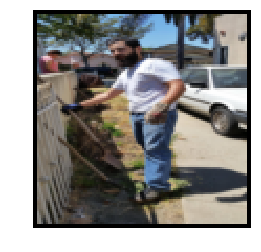

0


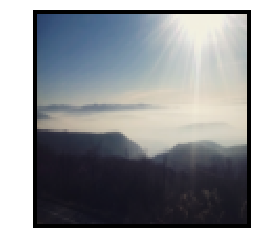

1


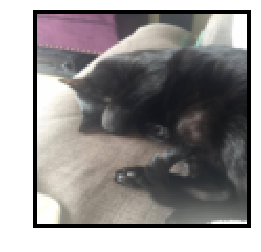

2


/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


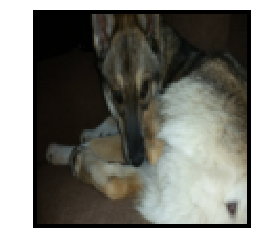

3


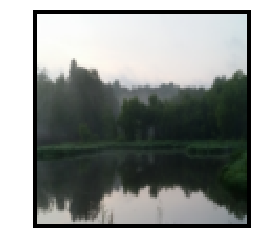

4


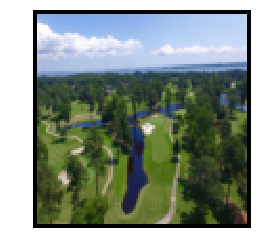

5


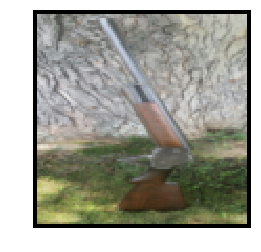

6


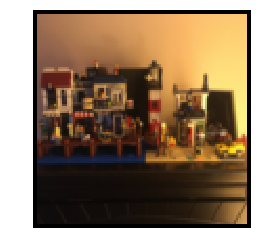

7


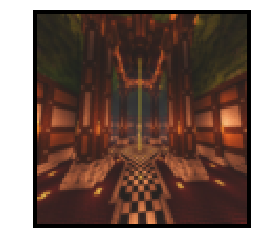

8


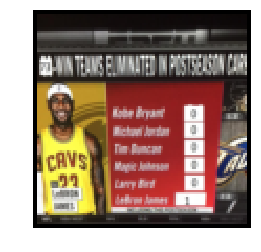

9


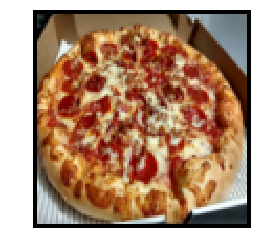

10


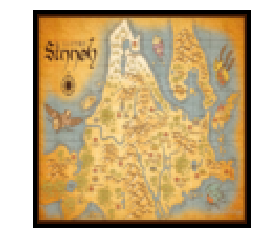

11


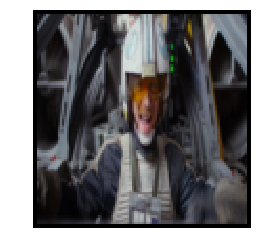

12


/home/shared/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (154000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


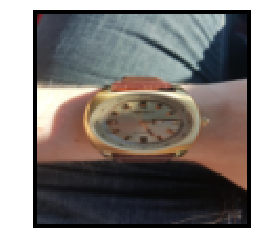

13


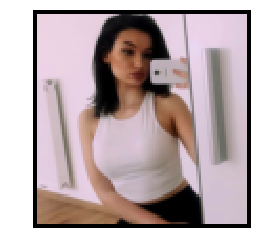

14
{0: 1066, 1: 1325, 2: 5975, 3: 1485, 4: 1564, 5: 1200, 6: 1947, 7: 1622, 8: 1884, 9: 1499, 10: 830, 11: 3237, 12: 1440, 13: 1624, 14: 2281}


In [7]:
#Final k-mean
sub_class = {}
sub_count = {}
transform=transforms.Compose([transforms.Scale((100,100)),transforms.ToTensor()])
for img_tuple in folder_dataset.imgs: 
    img = Image.open(img_tuple[0])
    img = img.convert("RGB")
    img = transform(img).view(1,3,100,100)
    output1 = net.forward_once(Variable(img).cuda())
    label_true = img_tuple[1]
    if label_true not in sub_class.keys():
        sub_class[label_true] = []
        sub_class[label_true].append(output1.cpu().data.numpy().squeeze())
        sub_count[label_true] = 1
        imshow(torchvision.utils.make_grid(img))
        print (img_tuple[1])
    else:
        sub_class[label_true].append(output1.cpu().data.numpy().squeeze())
        sub_count[label_true] += 1
print(sub_count)

# t-SNE Visualization 

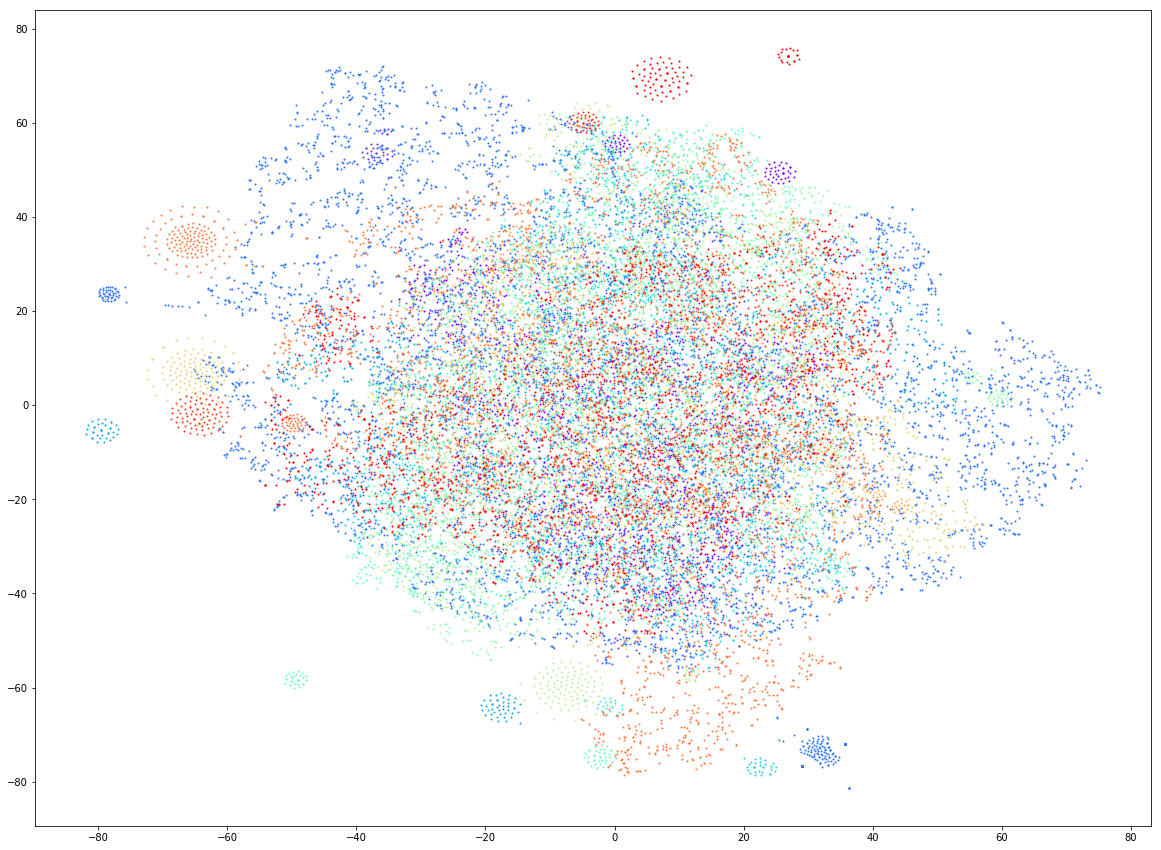

In [126]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 14))
for label, color in zip(sub_class, colors):
    cur = np.array(sub_class[label])
    X_embedded = manifold.TSNE(n_components = 2).fit_transform(cur)
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c = color, s = 1)

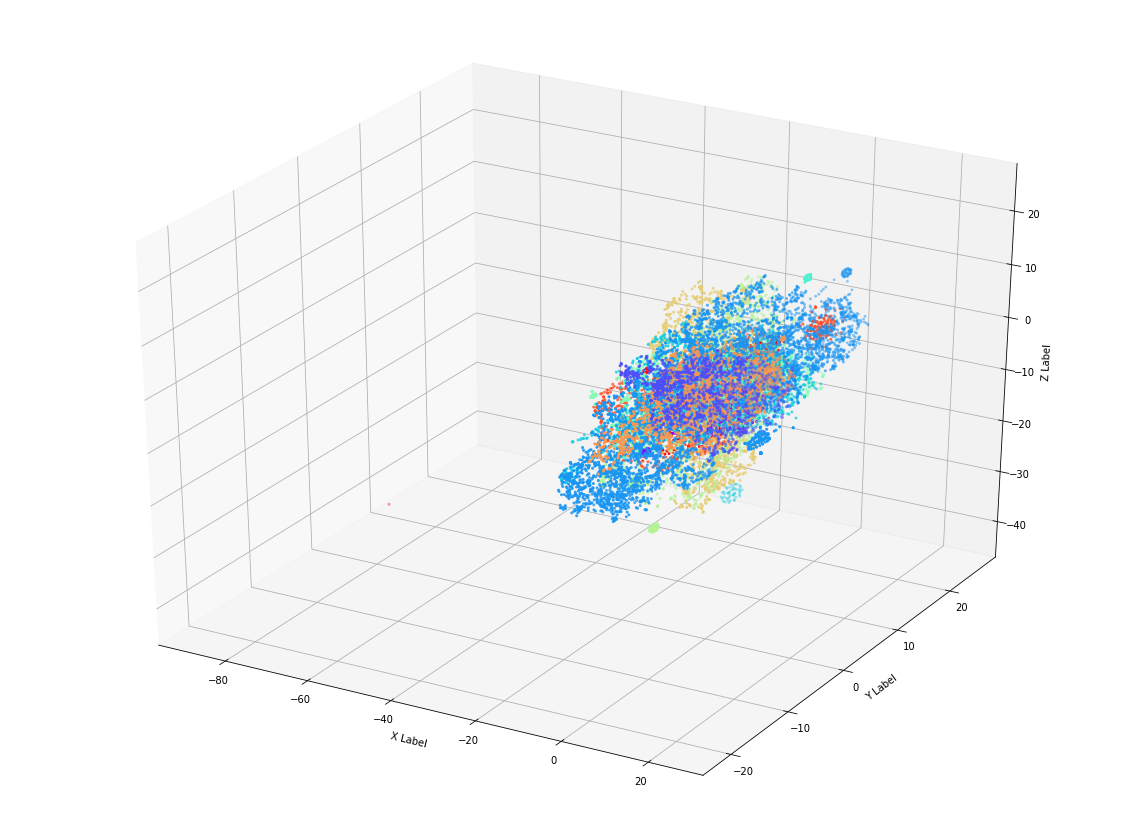

In [144]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = cm.rainbow(np.linspace(0, 1, 11))
for label, color in zip(sub_class, colors):
    cur = np.array(sub_class[label])
    X_embedded = manifold.TSNE(n_components = 3).fit_transform(cur)
    X_mask = X_embedded[:,1] > -500
    count = len(X_mask)
    X_embedded = X_mask.reshape(count,1) * X_embedded
    ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c = color, s = 4)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Get the Mean and Standard Deviation of feature vectors from training images for each class

In [81]:
sub_class_average = {}
for label in sub_class:
    sub_class_average[label] = sum(sub_class[label])/sub_count[label]

## Calculate the classification accuracy using test images by clustering according to the mean vectors of training images

In [111]:
count_true =0 
count = 0
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
transform=transforms.Compose([transforms.Scale((100,100)),transforms.ToTensor()])
for img_tuple in folder_dataset_test.imgs:
#     print (img_tuple)
    x1 = Image.open(img_tuple[0])
    x1 = x1.convert("RGB")
    x1 = transform(x1).view(1,3,100,100)
    label_true = img_tuple[1]
    count += 1 
#     _,x1,_,label_true = data
    output2 = net.forward_once(Variable(x1).cuda())
    pred = {}
    min_score = 10
    pred_class = None
    for label in sub_class:
#         print (label.cpu().data.numpy())
        output1 = sub_class_average[label]
        output1 = output1[np.newaxis,:]
        output1 = Variable(torch.FloatTensor(output1).cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        pred[label] = euclidean_distance.cpu().data.numpy()
        if pred[label] < min_score:
            pred_class =  label
            min_score = pred[label]
#     if pred_class == Variable(label_true).data[0]:    
    if pred_class == label_true: 
        count_true+=1
print (count_true/float(count))
    
print (count_true)
print (float(count))

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


0.9173333333333333
1376
1500.0




# Print out mean and standard deviations of feature vectors of training images

In [28]:
sub_class_average

{0: array([-0.27809006, -1.0289152 , -0.23910432,  0.0285873 ,  0.44797546],
       dtype=float32),
 1: array([-0.84600836,  0.5727777 ,  0.41666472,  0.16172418,  1.0201335 ],
       dtype=float32),
 2: array([-0.75776595, -0.3661846 ,  0.30761325, -1.4753653 ,  0.37378615],
       dtype=float32),
 3: array([-0.9998229 , -0.9224167 ,  0.5471706 ,  0.00431598,  0.63029504],
       dtype=float32),
 4: array([-1.678681  , -0.39787978, -0.5810501 , -0.5266661 ,  1.1648654 ],
       dtype=float32),
 5: array([-1.2589015 ,  0.68448067, -0.26202115, -0.30618024,  0.09385472],
       dtype=float32),
 6: array([-0.47921315,  0.35832116,  1.3822967 , -0.41285753,  0.01638568],
       dtype=float32),
 7: array([ 0.14605843, -0.15491048,  0.87090296,  0.86359036,  0.37423936],
       dtype=float32),
 8: array([-0.3149525 ,  0.17407554, -0.5329236 , -0.58720464,  0.85792017],
       dtype=float32),
 9: array([ 0.40933758, -0.24112053, -0.12714162, -0.7449329 , -0.07807782],
       dtype=float32),


In [29]:
sub_class_std

{0: array([0.13220124, 0.22757974, 0.18741362, 0.23798944, 0.09411014],
       dtype=float32),
 1: array([0.17264426, 0.22262101, 0.11580915, 0.21409297, 0.17529245],
       dtype=float32),
 2: array([0.18761286, 0.13449433, 0.12696926, 0.30291998, 0.12359592],
       dtype=float32),
 3: array([0.23641254, 0.17387083, 0.13006693, 0.21111345, 0.07072037],
       dtype=float32),
 4: array([0.268249  , 0.11548883, 0.18017052, 0.12214626, 0.14456841],
       dtype=float32),
 5: array([0.25860155, 0.2691533 , 0.19042473, 0.16968906, 0.20424913],
       dtype=float32),
 6: array([0.11796712, 0.17908995, 0.28006005, 0.18875653, 0.15808533],
       dtype=float32),
 7: array([0.17464435, 0.12907837, 0.14725433, 0.38200033, 0.1173938 ],
       dtype=float32),
 8: array([0.20324461, 0.2646654 , 0.39586714, 0.23610562, 0.20459008],
       dtype=float32),
 9: array([0.33491343, 0.19536746, 0.17630364, 0.19834621, 0.27237692],
       dtype=float32),
 10: array([0.23584202, 0.24841964, 0.20665494, 0.

## Get the Mean and Standard Deviation of RGB values from training images for each class

In [ ]:
sub_class = {}
sub_count = {}
transform=transforms.Compose([transforms.Scale((100,100)),transforms.ToTensor()])
for img_tuple in folder_dataset.imgs: 
    img = Image.open(img_tuple[0])
    img = img.convert("RGB")
    img = transform(img).view(1,3,-1)
    output1 = Variable(torch.mean(img, dim=2))
    label_true = img_tuple[1]
    if label_true not in sub_class.keys():
        sub_class[label_true] = []
        sub_class[label_true].append(output1.cpu().data.numpy().squeeze())
        sub_count[label_true] = 1
        imshow(torchvision.utils.make_grid(img))
        print (img_tuple[1])
    else:
        sub_class[label_true]+= output1.cpu().data.numpy().squeeze()
        sub_count[label_true] += 1
print(sub_count)
sub_class_average = {}
sub_class_std = {}
for label in sub_class:
    sub_class_average[label] = np.mean(sub_class[label], axis = 0)
    sub_class_std[label] = np.std(sub_class[label], axis = 0)

In [33]:
count_true =0 
count = 0
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
transform=transforms.Compose([transforms.Scale((100,100)),transforms.ToTensor()])
for img_tuple in folder_dataset_test.imgs:
#     print (img_tuple)
    x1 = Image.open(img_tuple[0])
    x1 = x1.convert("RGB")
    x1 = transform(x1).view(1,3,-1)
    x1 = Variable(torch.mean(x1, dim=2))
    label_true = img_tuple[1]
    count += 1 
#     _,x1,_,label_true = data
    output2 = x1
    pred = {}
    min_score = 10
    pred_class = None
    for label in sub_class:
#         print (label.cpu().data.numpy())
        output1 = sub_class_average[label]
        output1 = output1[np.newaxis,:]
        output1 = Variable(torch.FloatTensor(output1))
        euclidean_distance = F.pairwise_distance(output1, output2)
        pred[label] = euclidean_distance.cpu().data.numpy()
        if pred[label] < min_score:
            pred_class =  label
            min_score = pred[label]
#     if pred_class == Variable(label_true).data[0]:    
    if pred_class == label_true: 
        count_true+=1
print (count_true/float(count))
    
print (count_true)
print (float(count))

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


0.13866666666666666
208
1500.0
